# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from matplotlib import rcParams

from sklearn.ensemble import  RandomForestRegressor, IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [3]:
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

In [4]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [5]:
from keras.models import Sequential
from keras.layers import Dense

# Some preprocessing

In [6]:
data = pd.read_csv("./collected_data/prepared_data/prestep_data.csv")
data.head()

vertices  redexes  redex_depths  redex_indexes  heights  widths  \
0        53        3             4             12       15      21   
1        50        2             5             27       15      20   
2        27        1             1              1        8      10   
3        54        6             7             10       13      17   
4        51        6            11             16       14      16   

   steps_time strategy_name  
0      131224            LI  
1      187277            LI  
2       32085            LI  
3      179030            LI  
4      179197            LI

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3931 entries, 0 to 3930
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   vertices       3931 non-null   int64 
 1   redexes        3931 non-null   int64 
 2   redex_depths   3931 non-null   int64 
 3   redex_indexes  3931 non-null   int64 
 4   heights        3931 non-null   int64 
 5   widths         3931 non-null   int64 
 6   steps_time     3931 non-null   int64 
 7   strategy_name  3931 non-null   object
dtypes: int64(7), object(1)
memory usage: 245.8+ KB


In [8]:
pca = PCA(2, random_state=42)
data_pca = pca.fit_transform(data[["vertices", "redexes", "redex_depths", "heights", "widths"]])

C:\Users\voldo\AppData\Local\Temp\ipykernel_23716\2351182786.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], palette="deep")


<AxesSubplot: >

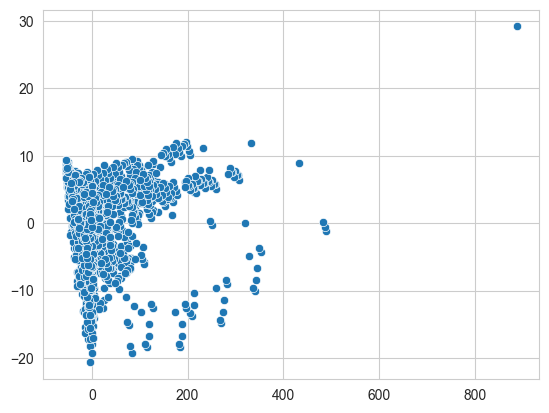

In [9]:
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], palette="deep")

<AxesSubplot: >

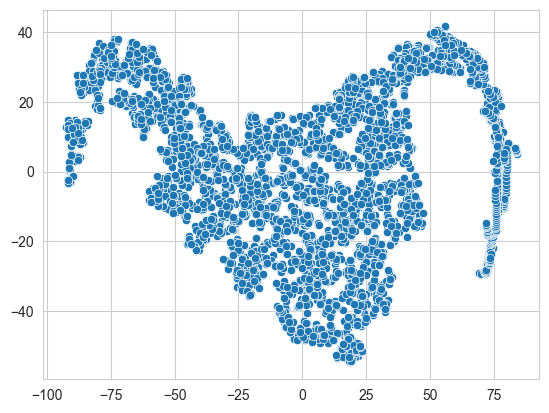

In [10]:
tsne = TSNE(random_state=3)
tsne_feature = tsne.fit_transform(data[["vertices", "redexes", "redex_depths", "heights", "widths"]])
sns.scatterplot(x=tsne_feature[:, 0], y=tsne_feature[:, 1])

## Check skewed features

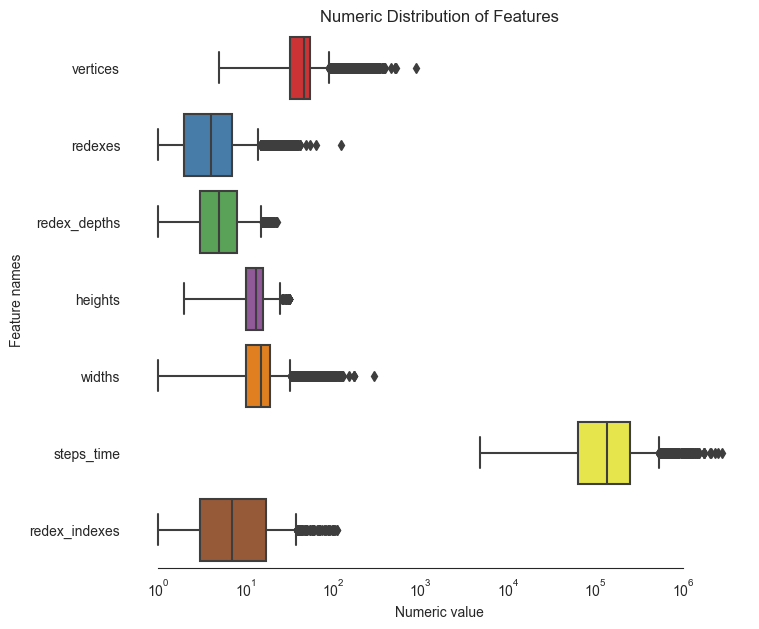

In [11]:
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=data[["vertices", "redexes", "redex_depths", "heights", "widths", "steps_time", "redex_indexes"]], orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric value")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [12]:
# Find skewed numerical features
skew_features = data[["vertices", "redexes", "redex_depths", "heights", "widths", "steps_time", "redex_indexes"]].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print(f"There are {high_skew.shape[0]} numerical features with skew > 0.5: ")
skewness = pd.DataFrame({"skew": skew_features})
skewness.head(10)

There are 6 numerical features with skew > 0.5: 


skew
vertices       4.235690
widths         4.148381
redexes        3.953192
steps_time     3.692667
redex_indexes  2.305134
redex_depths   1.034103
heights        0.428418

array([[<AxesSubplot: title={'center': 'vertices'}>,
        <AxesSubplot: title={'center': 'redexes'}>,
        <AxesSubplot: title={'center': 'redex_depths'}>],
       [<AxesSubplot: title={'center': 'redex_indexes'}>,
        <AxesSubplot: title={'center': 'heights'}>,
        <AxesSubplot: title={'center': 'widths'}>],
       [<AxesSubplot: title={'center': 'steps_time'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

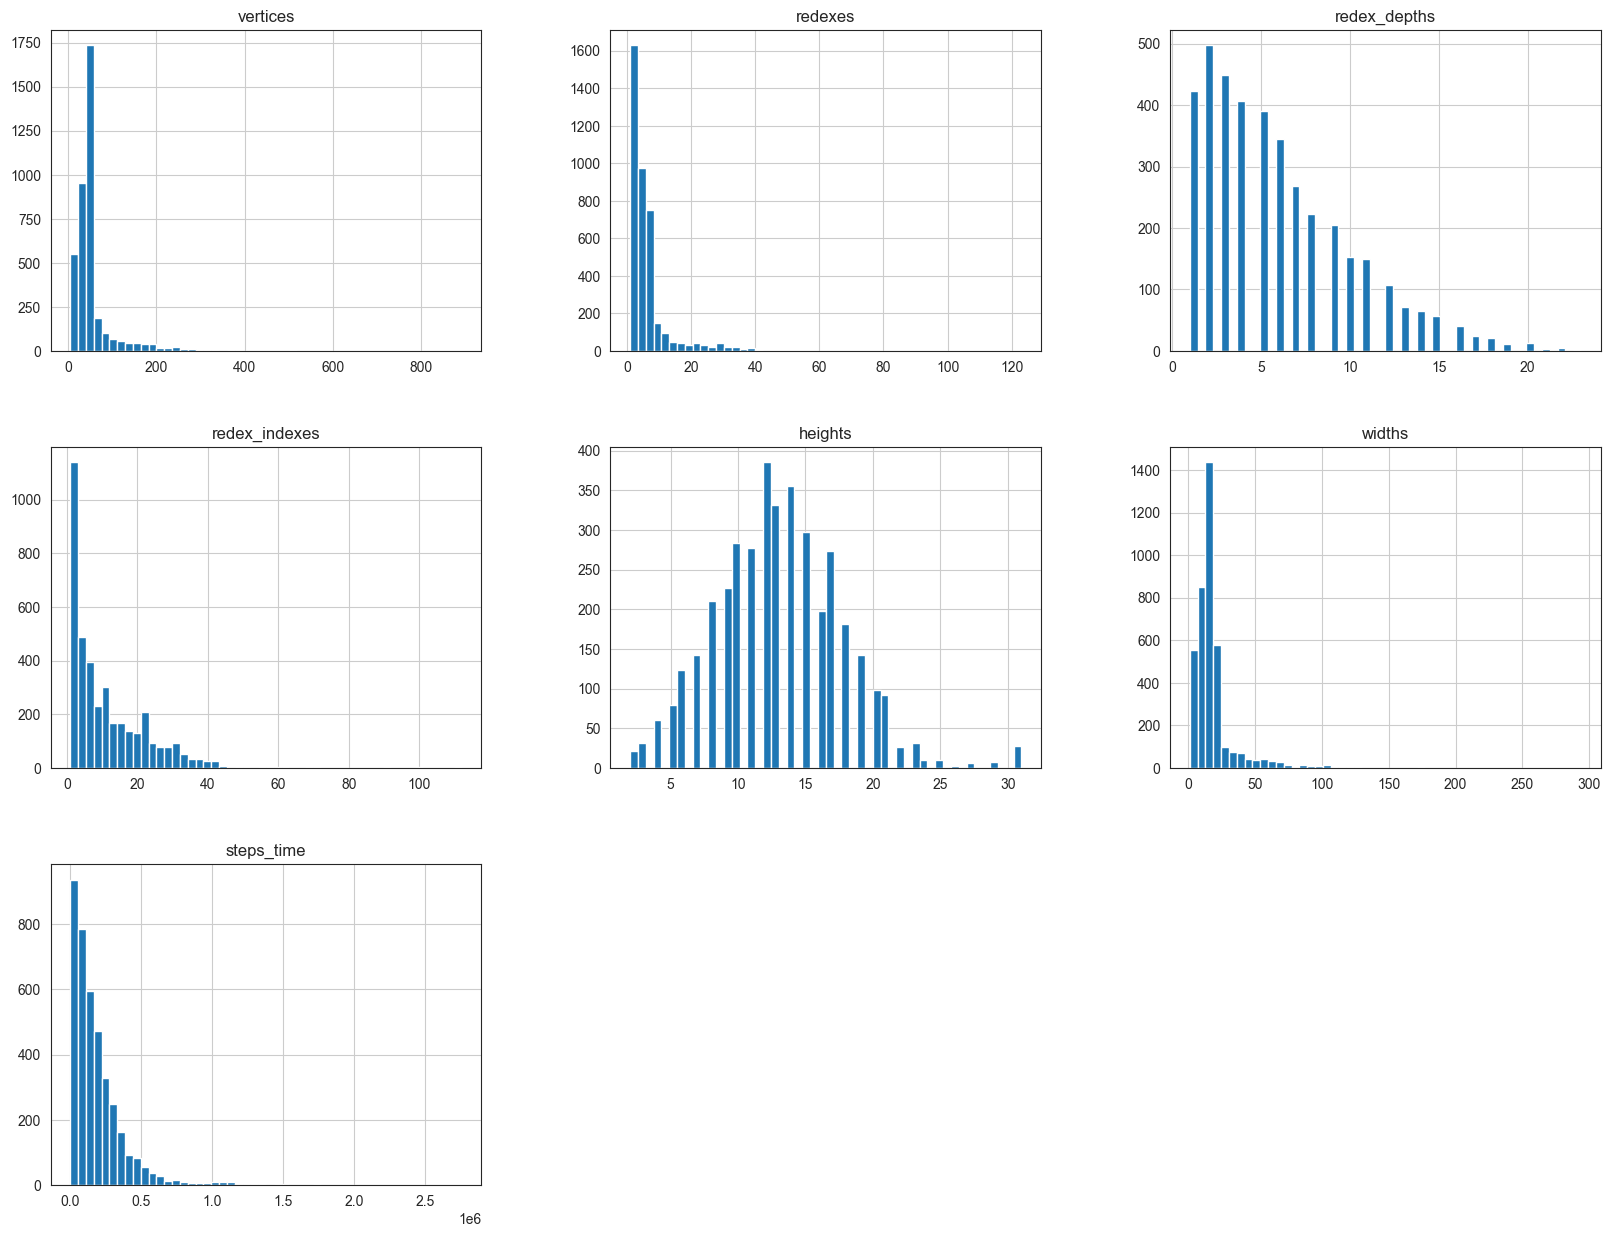

In [13]:
rcParams['figure.figsize'] = 20, 15
data.hist(bins=50)

array([[<AxesSubplot: title={'center': 'vertices'}>,
        <AxesSubplot: title={'center': 'redexes'}>],
       [<AxesSubplot: title={'center': 'redex_depths'}>,
        <AxesSubplot: title={'center': 'heights'}>],
       [<AxesSubplot: title={'center': 'widths'}>,
        <AxesSubplot: title={'center': 'steps_time'}>]], dtype=object)

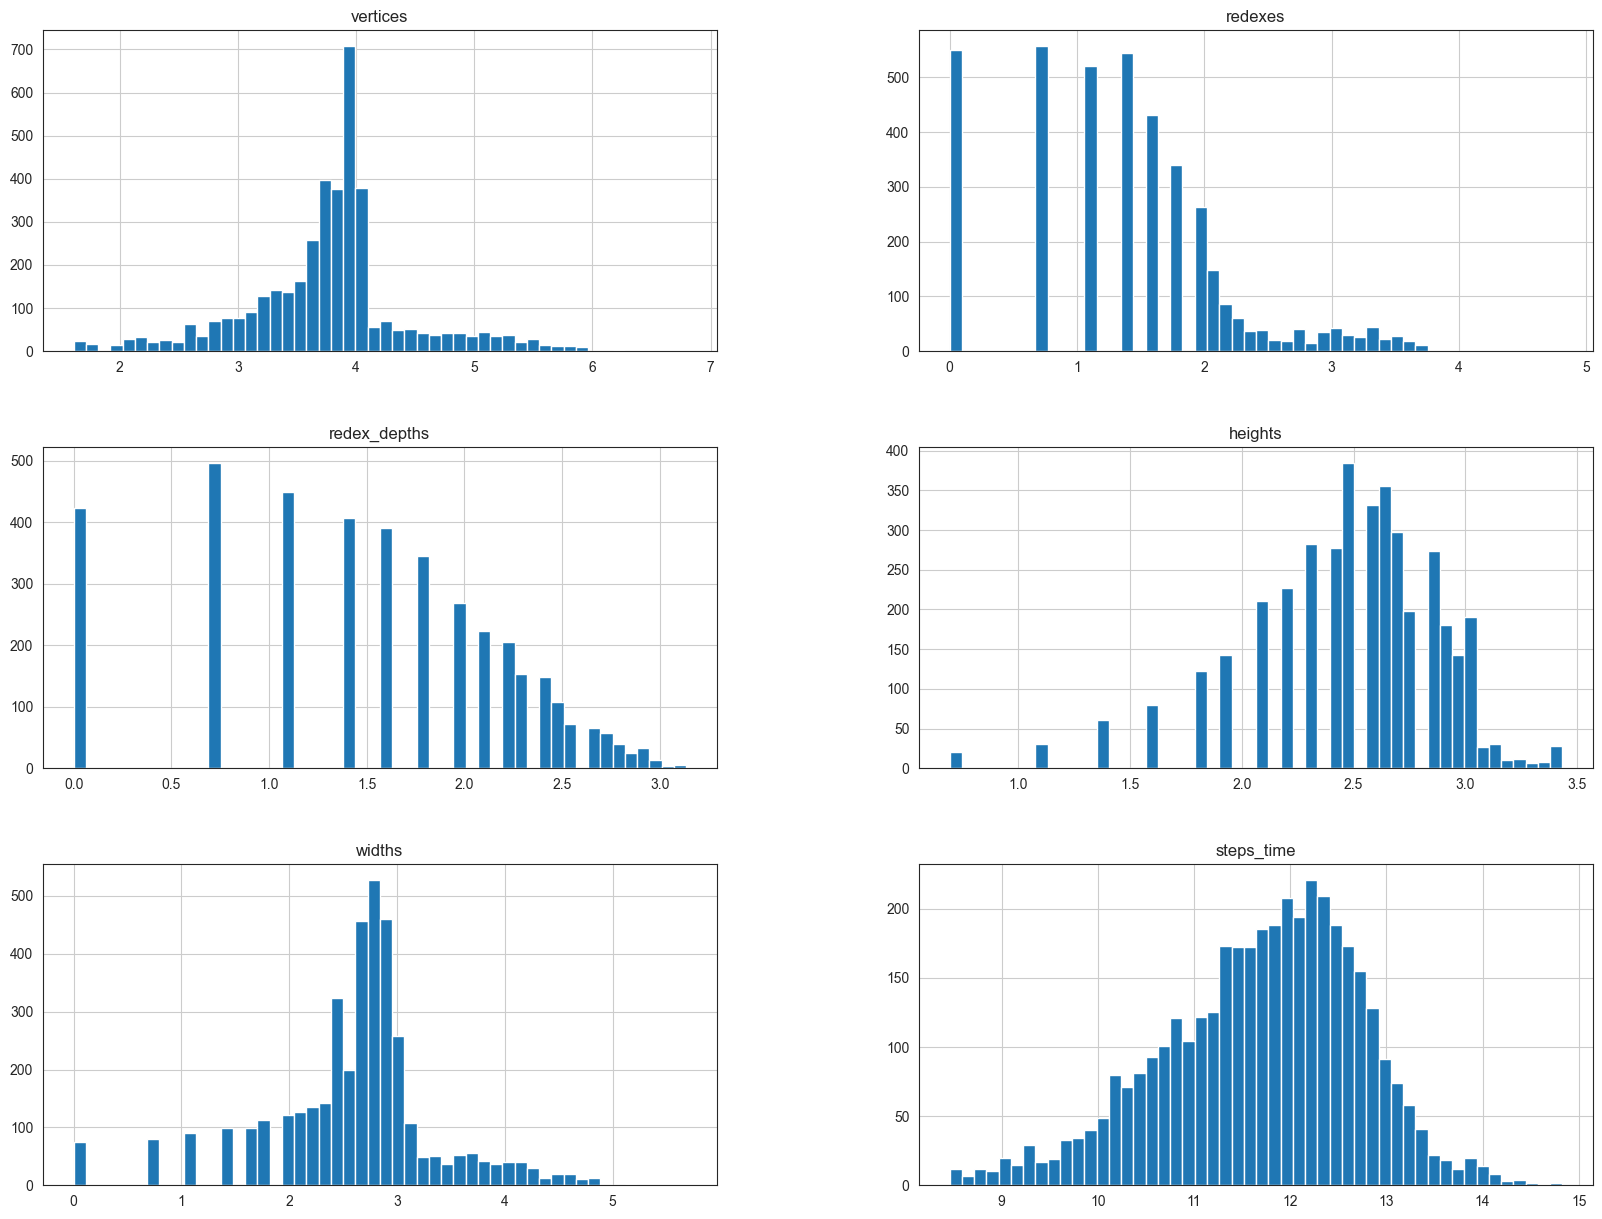

In [14]:
data_log = pd.DataFrame()
for col_name in ["vertices", "redexes", "redex_depths", "heights", "widths", "steps_time"]:
    data_log[col_name] = np.log(data[col_name])

data_log.hist(bins=50)

In [15]:
# data_for_training = data[["vertices", "redexes", "redex_depths", "heights", "widths", "steps_time"]]
data_for_training = data_log


def split_dataset(dataset, test_ratio=0.3):
    test_indices_filter = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices_filter], dataset[test_indices_filter]


train_ds, test_ds = split_dataset(data_for_training)
print(f"Examples for training {len(train_ds)}")
print(f"Examples for testing {len(test_ds)}")

Examples for training 2734
Examples for testing 1197


In [16]:
x_train, y_train = train_ds[["vertices", "redexes", "redex_depths", "heights", "widths"]], train_ds[["steps_time"]]
x_test, y_test = test_ds[["vertices", "redexes", "redex_depths", "heights", "widths"]], test_ds[["steps_time"]]

In [17]:
x_data, y_data = data_for_training[["vertices", "redexes", "redex_depths", "heights", "widths"]], data_for_training[["steps_time"]]

# Functions for drawing predicted values

In [18]:
rcParams['figure.figsize'] = 10, 12

def draw_pred_lines(y_pred, y_real):
    drawing_df = pd.DataFrame({"Pred": y_pred, "Real": y_real})
    drawing_df = drawing_df.sort_values("Real").reset_index(drop=True)

    for key_, val_ in drawing_df.items():
        plt.plot(range(len(val_)), val_, label=key_)

    plt.xlabel("No")
    plt.ylabel("Step Time")
    plt.title("Pred vs Real Step Time")
    plt.legend()
    plt.show()

# 1. Linear Regression

In [19]:
lin_regressor = LinearRegression()
lin_regressor.fit(x_train, y_train)

y_train_pred = lin_regressor.predict(x_train)
y_test_pred = lin_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)

TRAIN Root Mean Squared Error(RMSE): 0.28815379514519784
TEST Root Mean Squared Error(RMSE): 0.2974677395358567


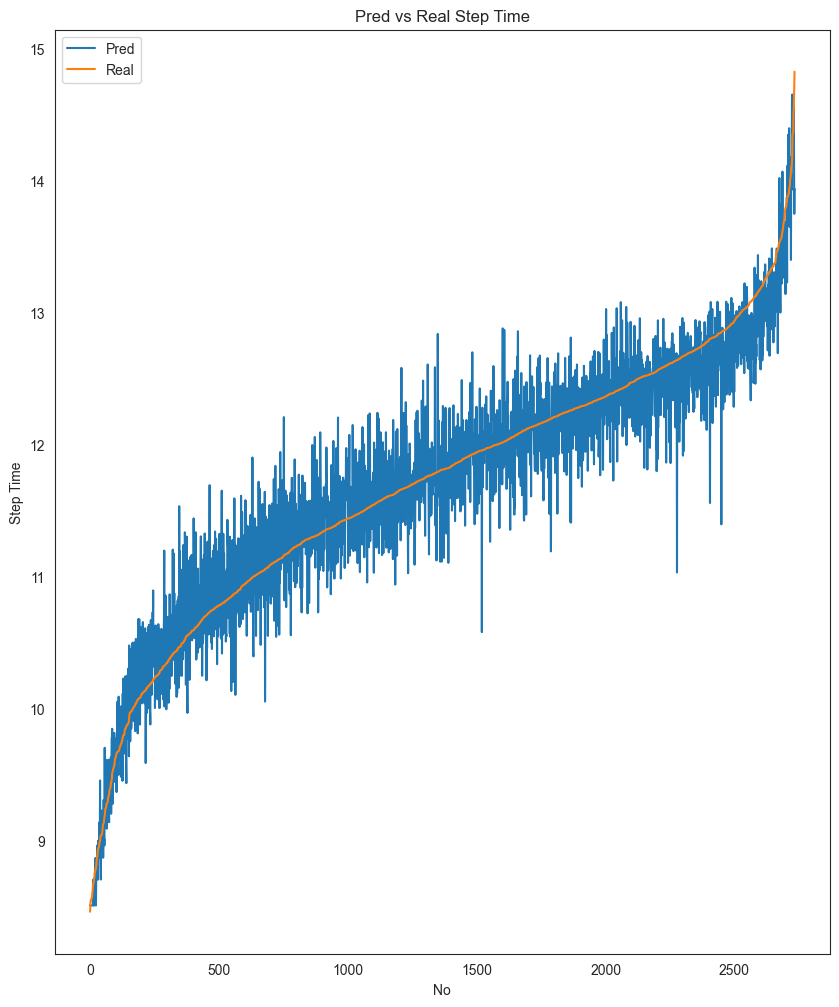

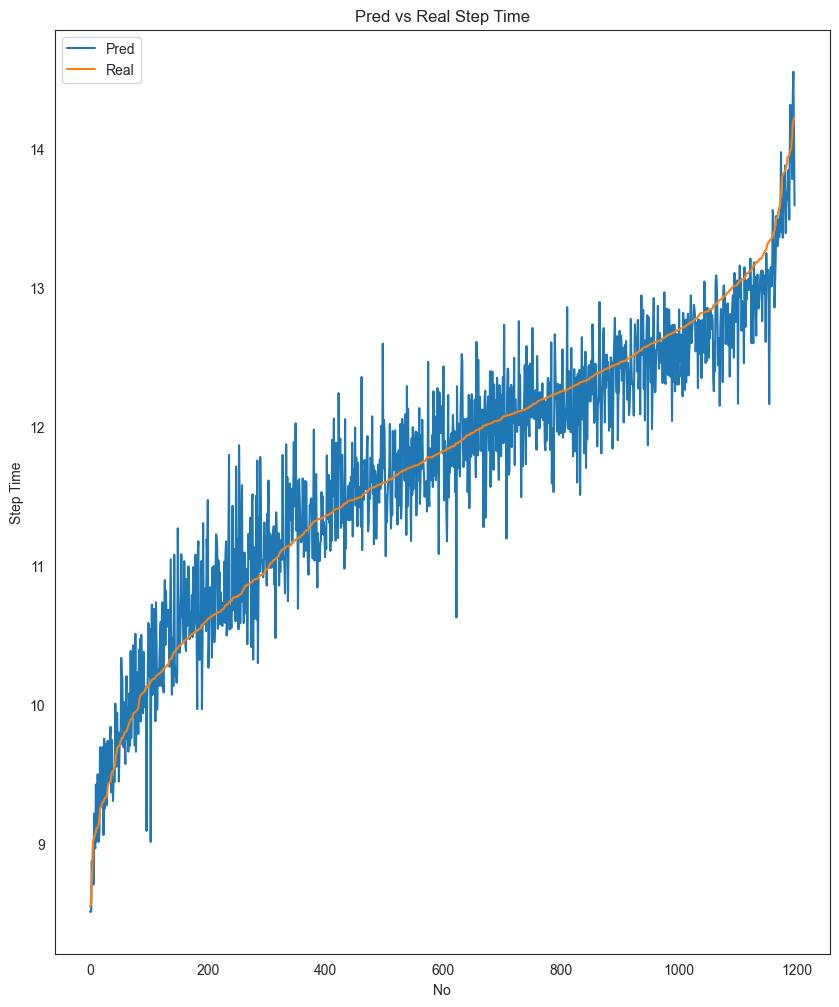

In [20]:
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

In [21]:
lin_regressor = LinearRegression()
lin_regressor.fit(x_train, y_train)

y_data_pred = lin_regressor.predict(x_data)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)
print("ALL RMSE:", rmse_all)

ALL RMSE: 0.2910214822947875


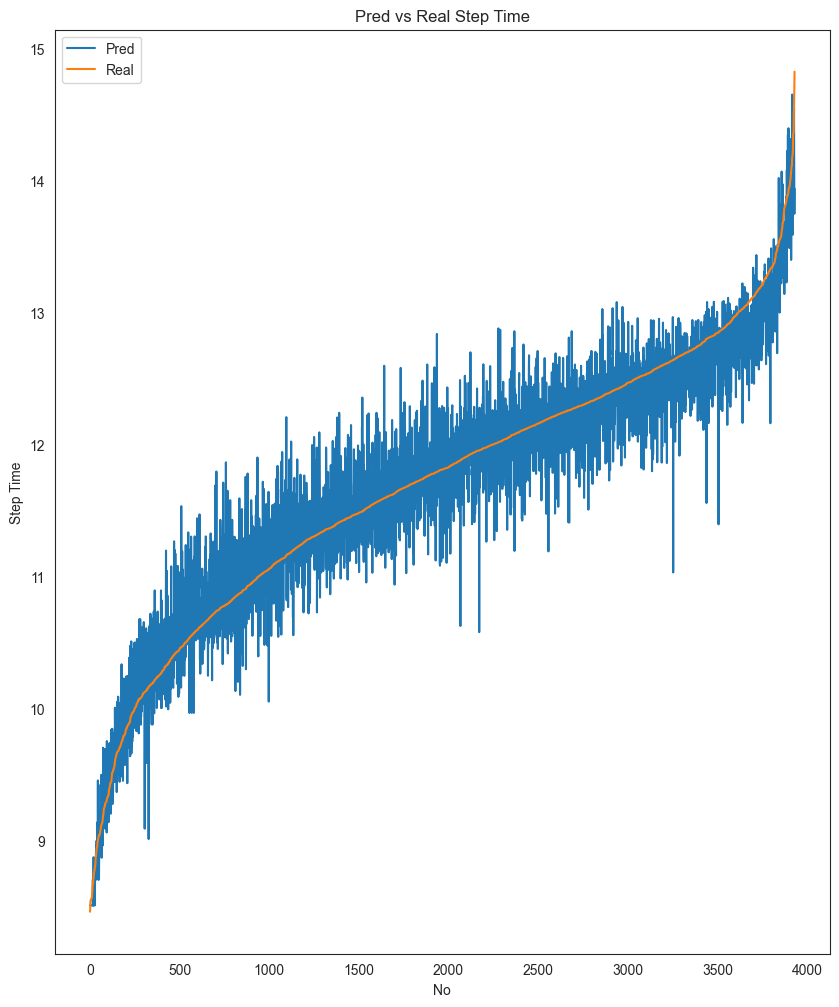

In [22]:
draw_pred_lines(list(y_data_pred[:, -1]), y_data["steps_time"].to_list())

# 2. Decision Tree Regression

In [23]:
dt_regressor = DecisionTreeRegressor()
dt_regressor.fit(x_train, y_train)

y_train_pred = dt_regressor.predict(x_train)
y_test_pred = dt_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)

TRAIN Root Mean Squared Error(RMSE): 0.049773766067009034
TEST Root Mean Squared Error(RMSE): 0.40521313191990976


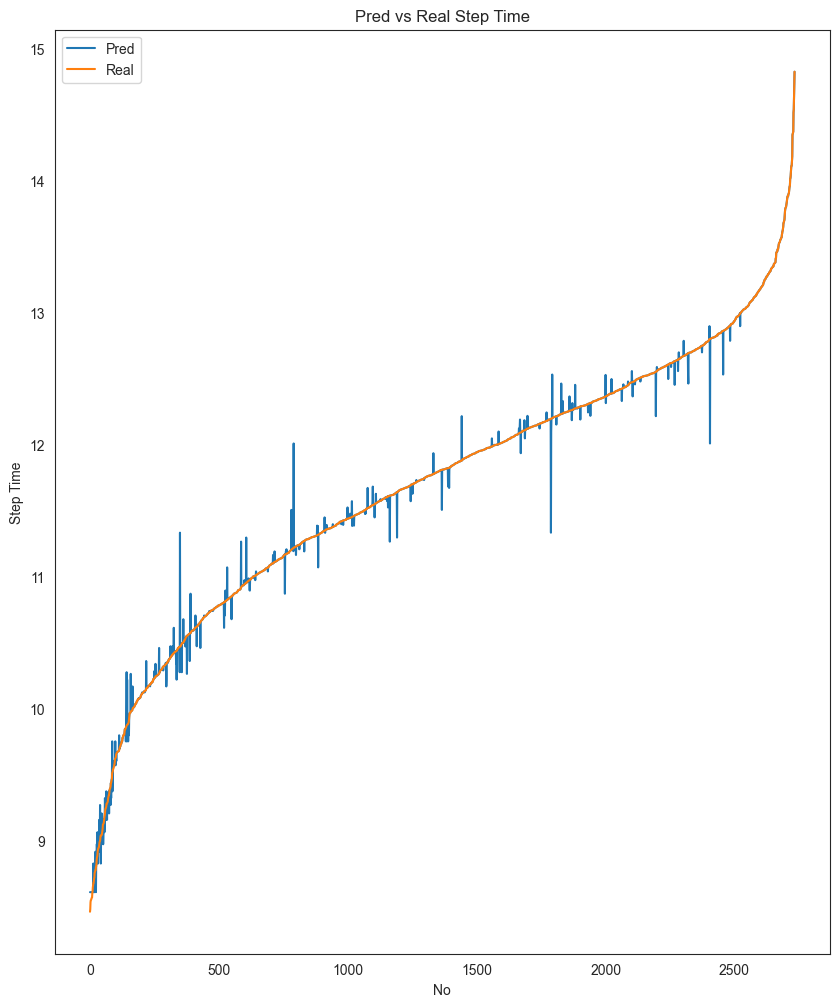

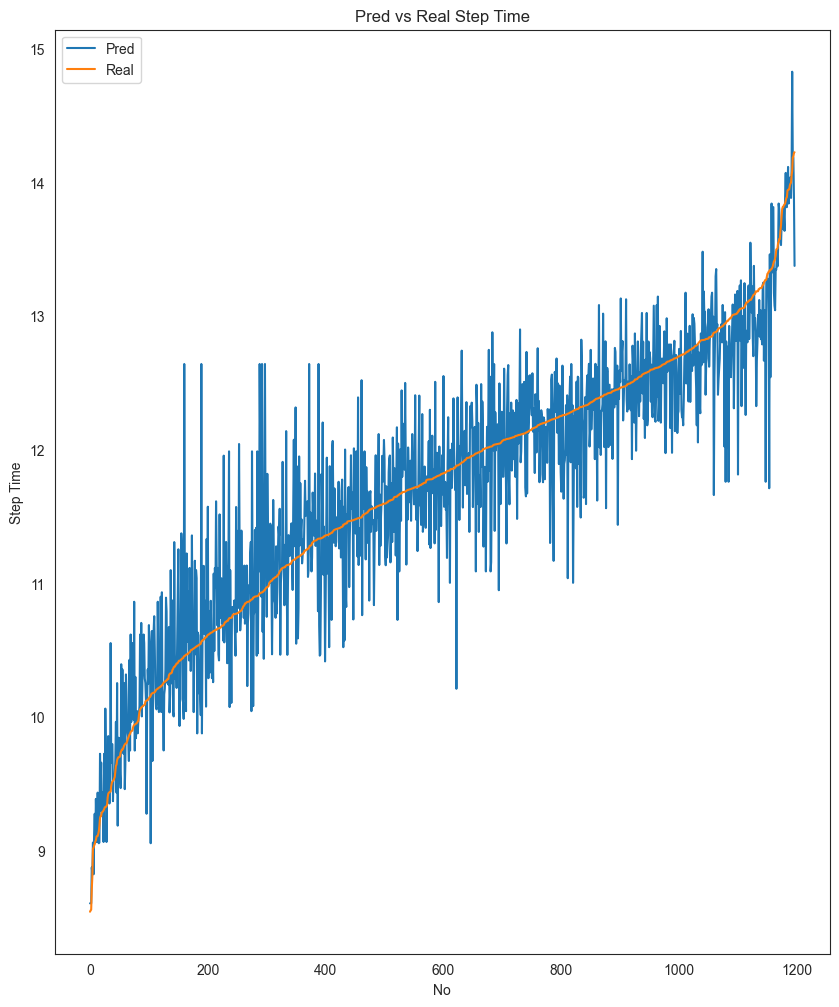

In [24]:
draw_pred_lines(list(y_train_pred), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred), y_test["steps_time"].to_list())

In [25]:
dt_regressor = DecisionTreeRegressor()
dt_regressor.fit(x_train, y_train)

y_data_pred = dt_regressor.predict(x_data)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)
print("ALL RMSE:", rmse_all)

ALL RMSE: 0.2196100494242035


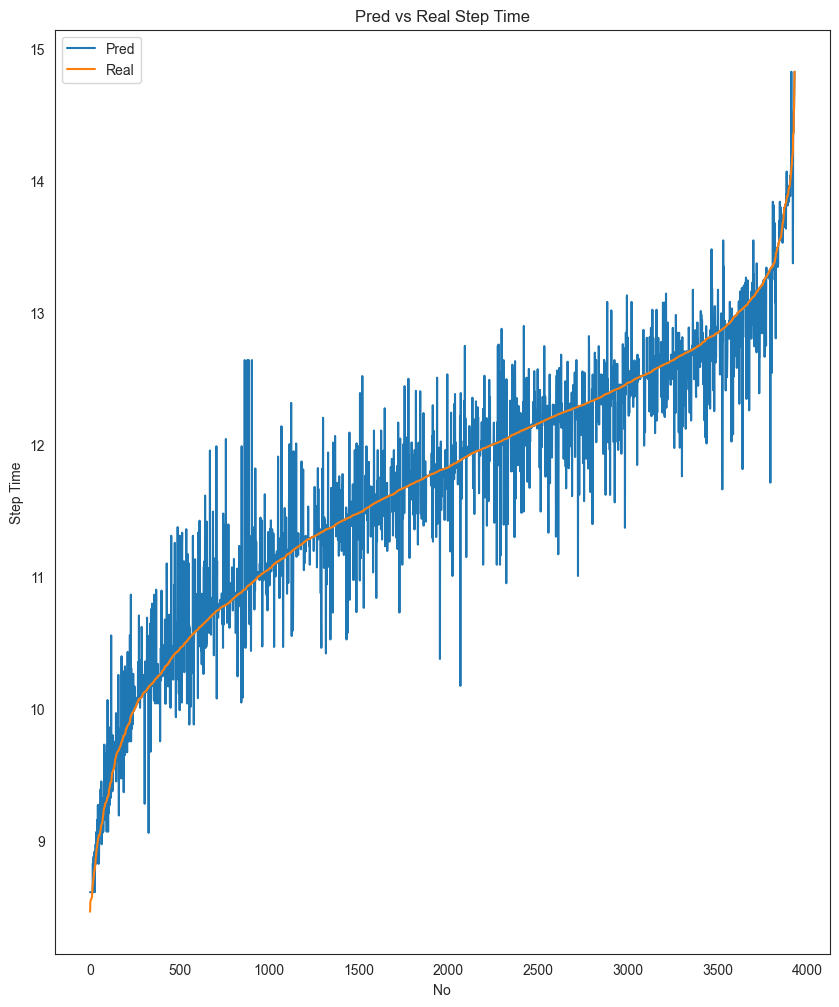

In [26]:
draw_pred_lines(list(y_data_pred), y_data["steps_time"].to_list())

# 3. Random Forest

In [27]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(x_train, y_train)

y_train_pred = rf_regressor.predict(x_train)
y_test_pred = rf_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)

D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


TRAIN Root Mean Squared Error(RMSE): 0.1119282923229805
TEST Root Mean Squared Error(RMSE): 0.3010751895767577


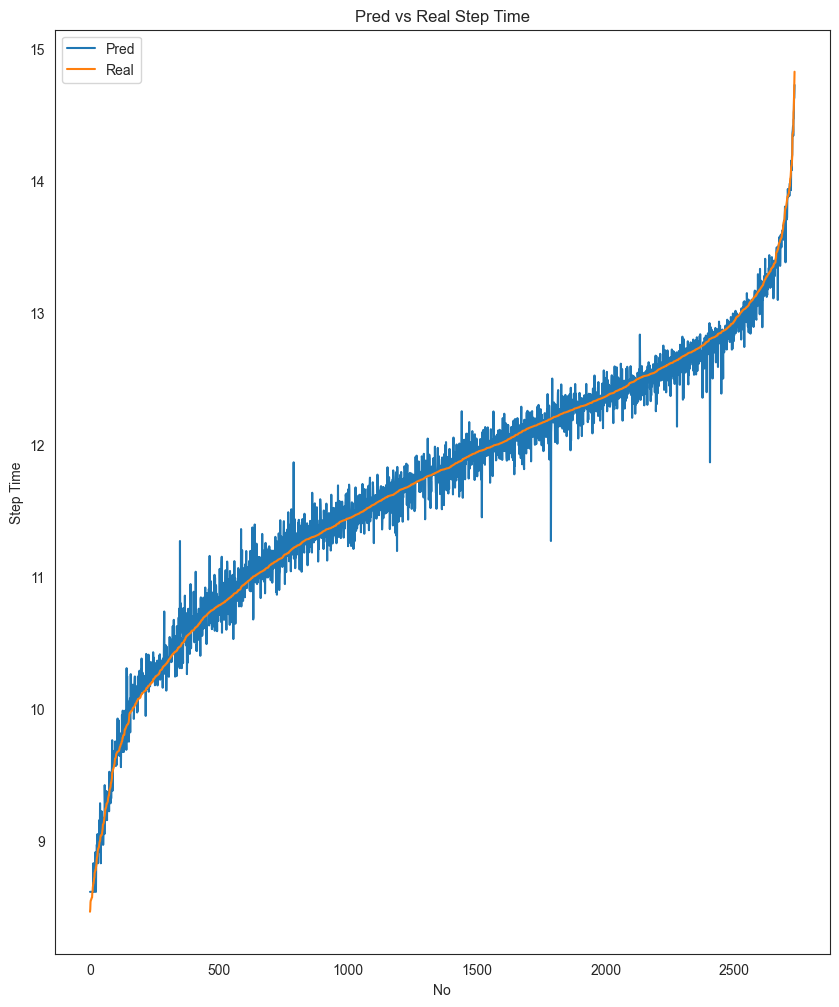

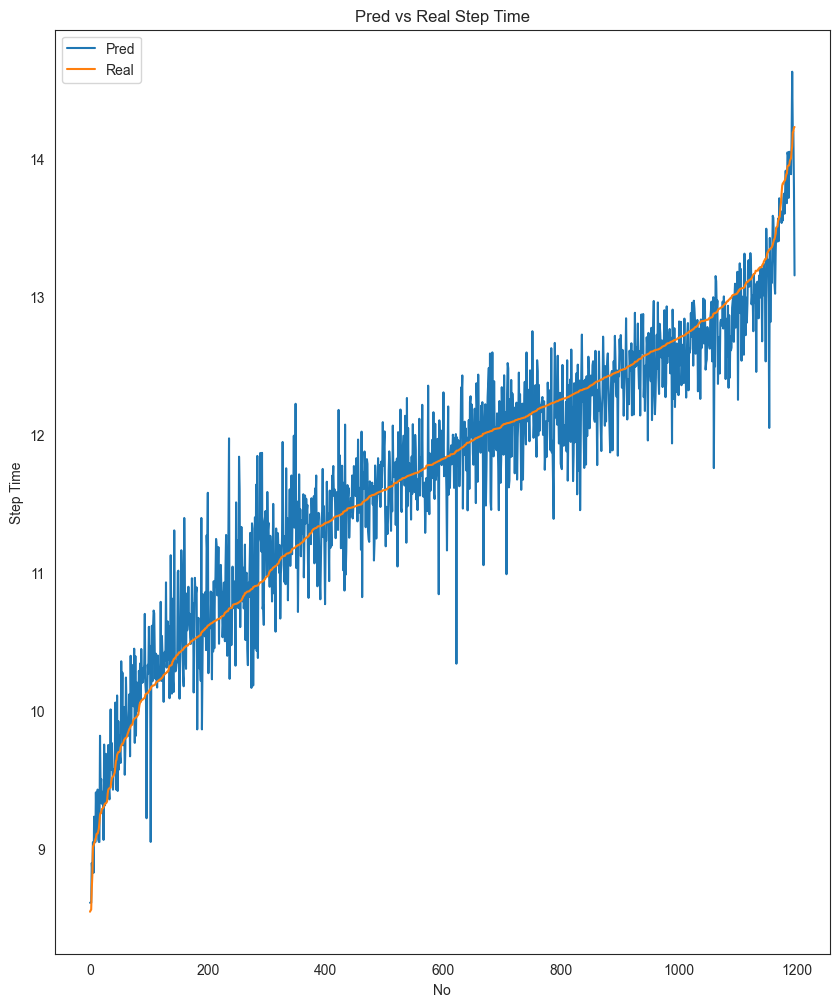

In [28]:
draw_pred_lines(list(y_train_pred), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred), y_test["steps_time"].to_list())

In [29]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(x_data, y_data)

y_data_pred = rf_regressor.predict(x_data)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)
print("ALL RMSE:", rmse_all)

D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


ALL RMSE: 0.113438171503864


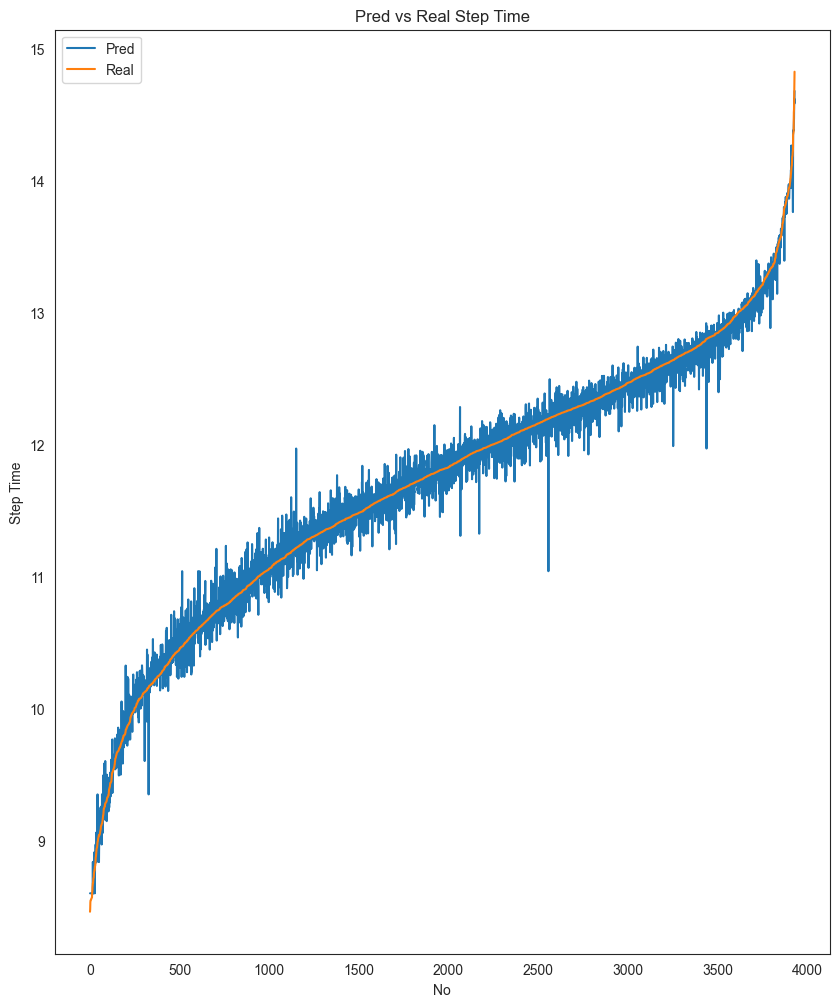

In [30]:
draw_pred_lines(list(y_data_pred), y_data["steps_time"].to_list())

# 4. Support Vector Regression
### kernel='rbf'

In [31]:
svr_regressor = SVR(kernel="rbf")
svr_regressor.fit(x_train, y_train)

y_train_pred = svr_regressor.predict(x_train)
y_test_pred = svr_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)

D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN Root Mean Squared Error(RMSE): 0.274480678604193
TEST Root Mean Squared Error(RMSE): 0.2892846191963762


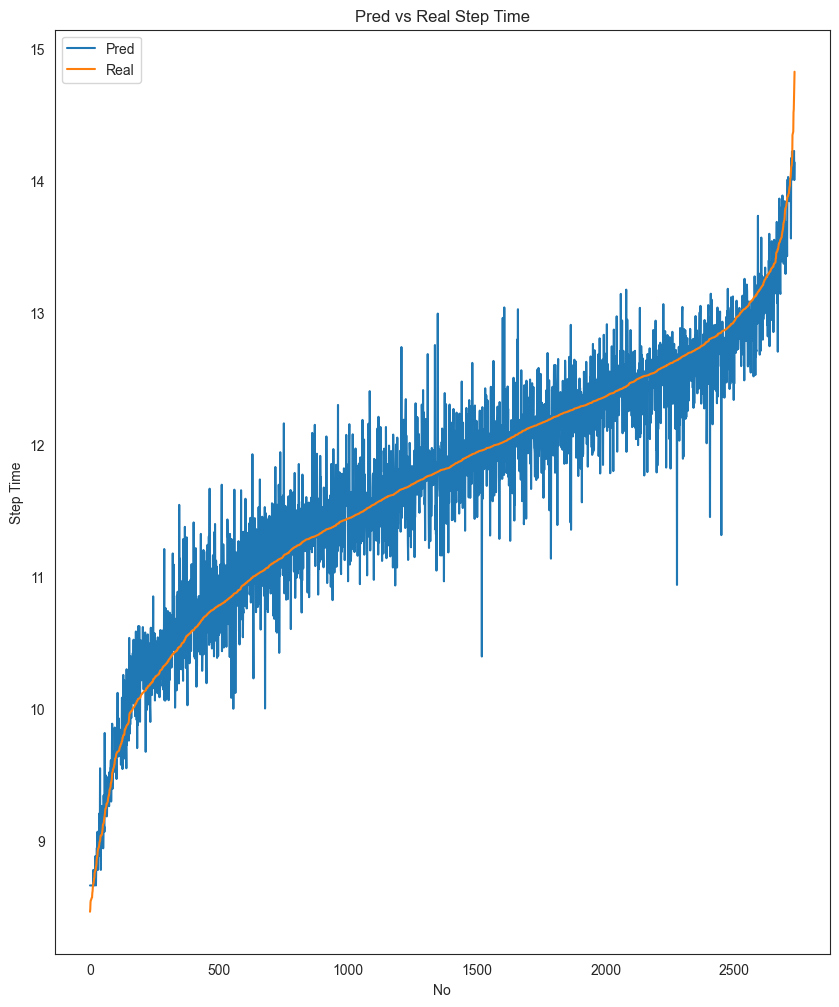

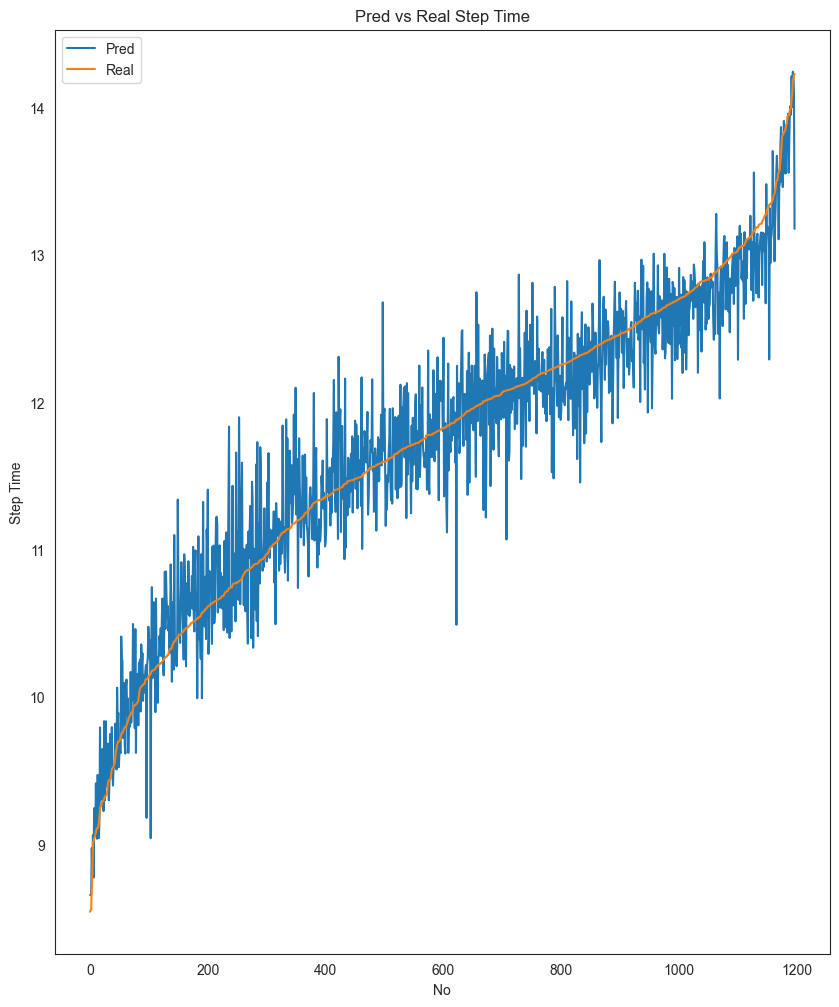

In [32]:
draw_pred_lines(list(y_train_pred), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred), y_test["steps_time"].to_list())

In [33]:
svr_regressor = SVR(kernel="rbf")
svr_regressor.fit(x_data, y_data)

y_data_pred = svr_regressor.predict(x_data)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)
print("ALL RMSE:", rmse_all)

D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ALL RMSE: 0.2772079578069792


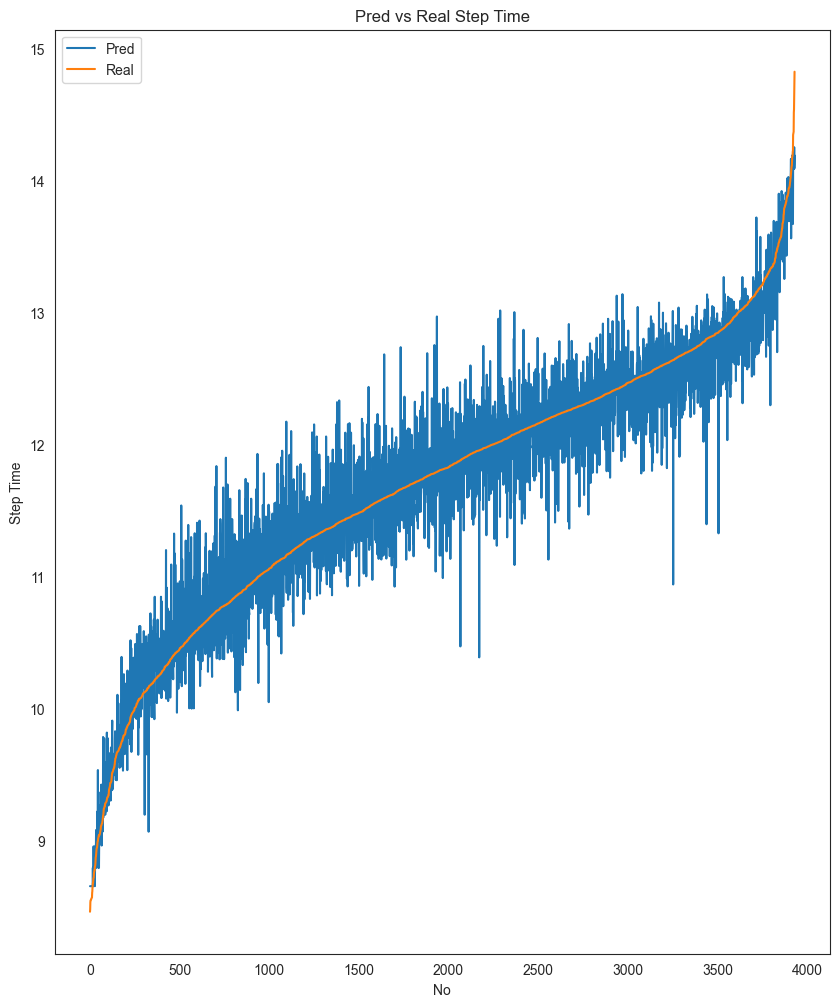

In [34]:
draw_pred_lines(list(y_data_pred), y_data["steps_time"].to_list())

### kernel='linear'

In [35]:
svr_regressor = SVR(kernel="linear")
svr_regressor.fit(x_train, y_train)

y_train_pred = svr_regressor.predict(x_train)
y_test_pred = svr_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)


svr_regressor = SVR(kernel="linear")
svr_regressor.fit(x_data, y_data)

y_data_pred = svr_regressor.predict(x_data)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)
print("ALL RMSE:", rmse_all)

D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN Root Mean Squared Error(RMSE): 0.2885721939730832
TEST Root Mean Squared Error(RMSE): 0.29791881187425207


D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ALL RMSE: 0.29127761644126104


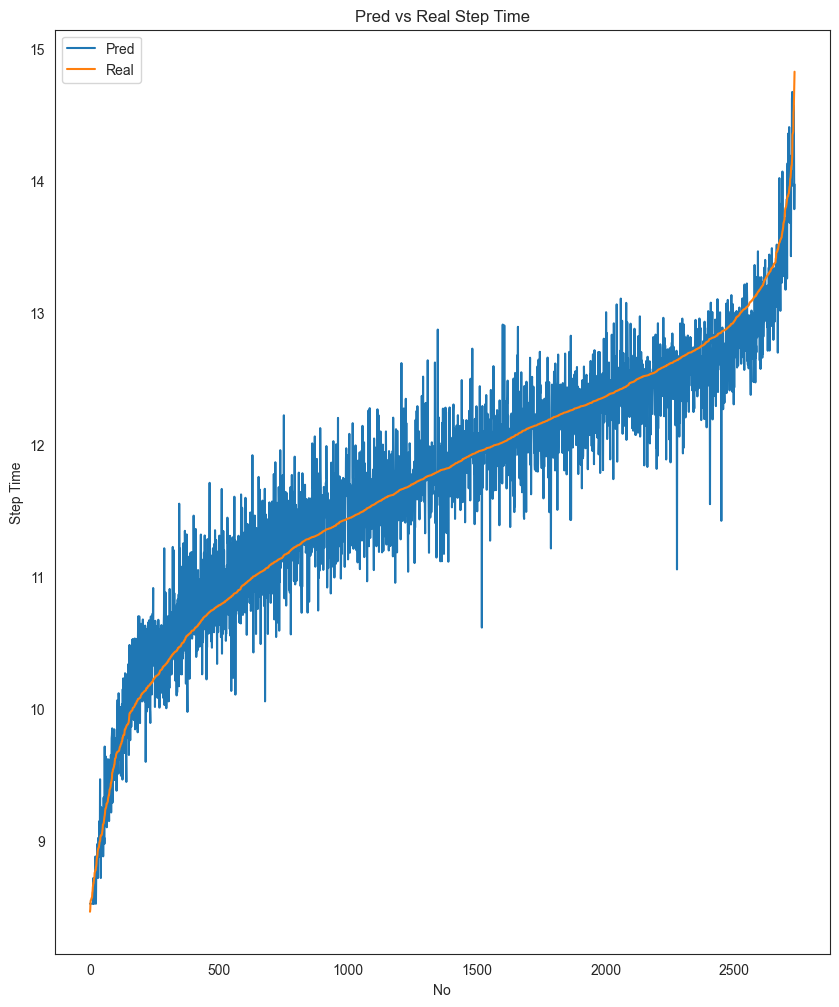

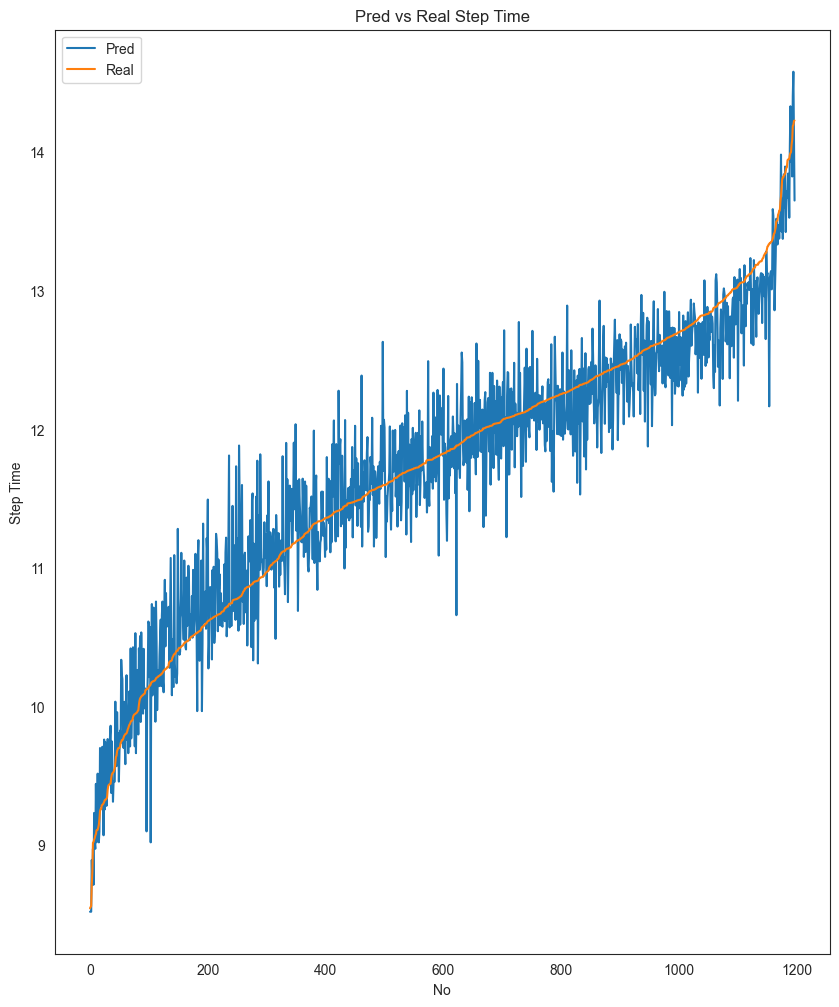

In [36]:
draw_pred_lines(list(y_train_pred), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred), y_test["steps_time"].to_list())

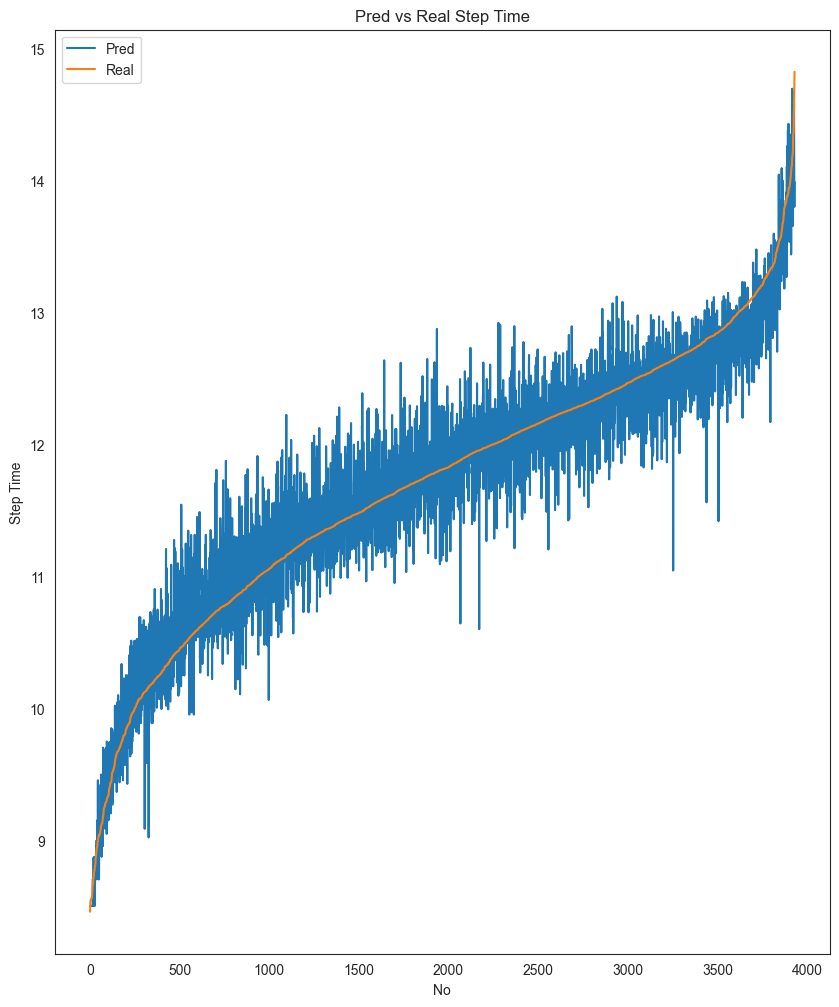

In [37]:
draw_pred_lines(list(y_data_pred), y_data["steps_time"].to_list())

### kernel='poly'

In [38]:
svr_regressor = SVR(kernel="poly")
svr_regressor.fit(x_train, y_train)

y_train_pred = svr_regressor.predict(x_train)
y_test_pred = svr_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)


svr_regressor = SVR(kernel="poly")
svr_regressor.fit(x_data, y_data)

y_data_pred = svr_regressor.predict(x_data)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)
print("ALL RMSE:", rmse_all)

D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN Root Mean Squared Error(RMSE): 0.31498635696942173
TEST Root Mean Squared Error(RMSE): 0.3211158016248923


D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ALL RMSE: 0.31591119756083974


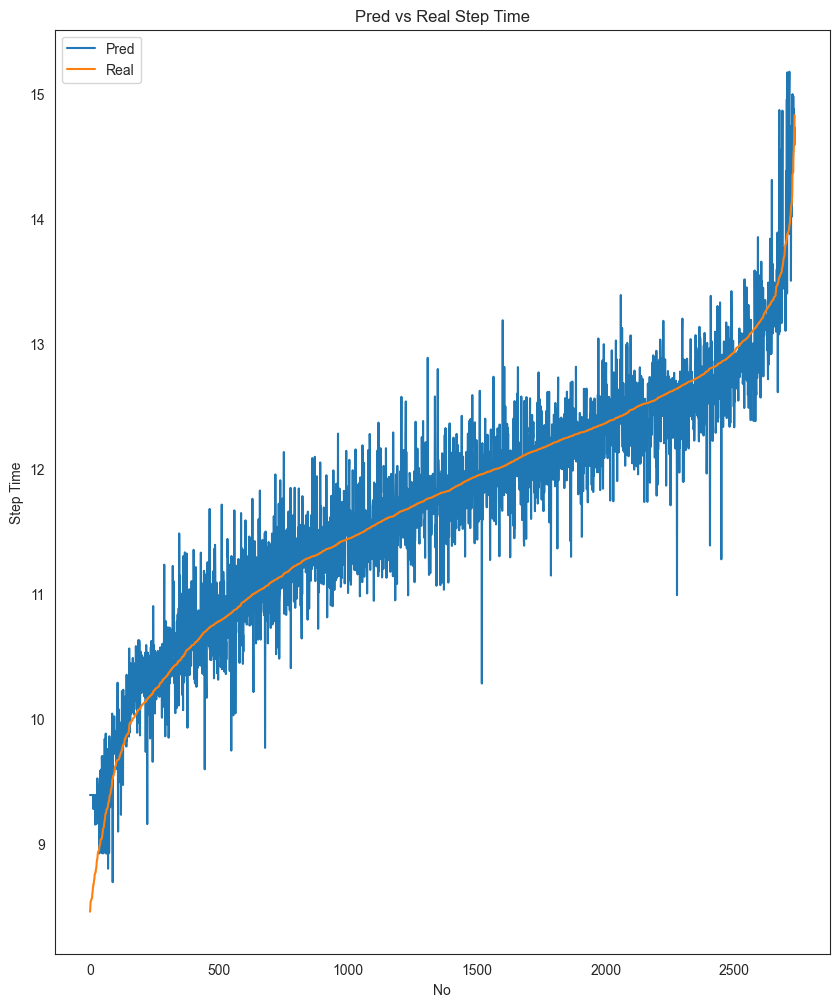

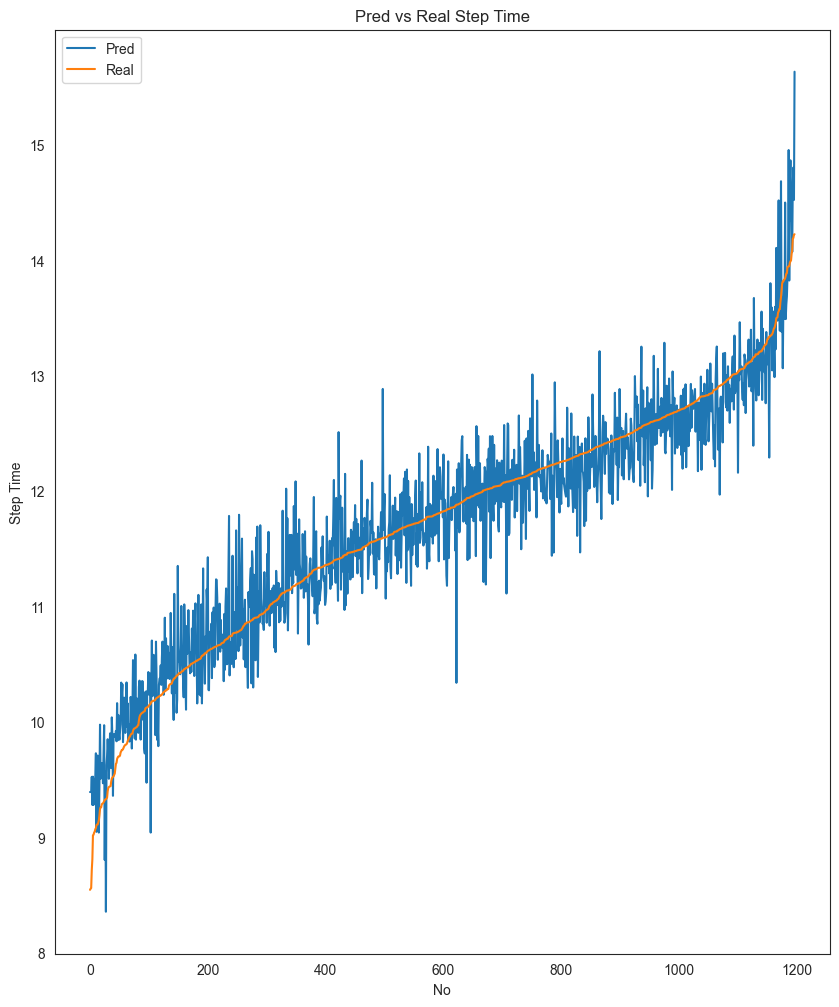

In [39]:
draw_pred_lines(list(y_train_pred), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred), y_test["steps_time"].to_list())

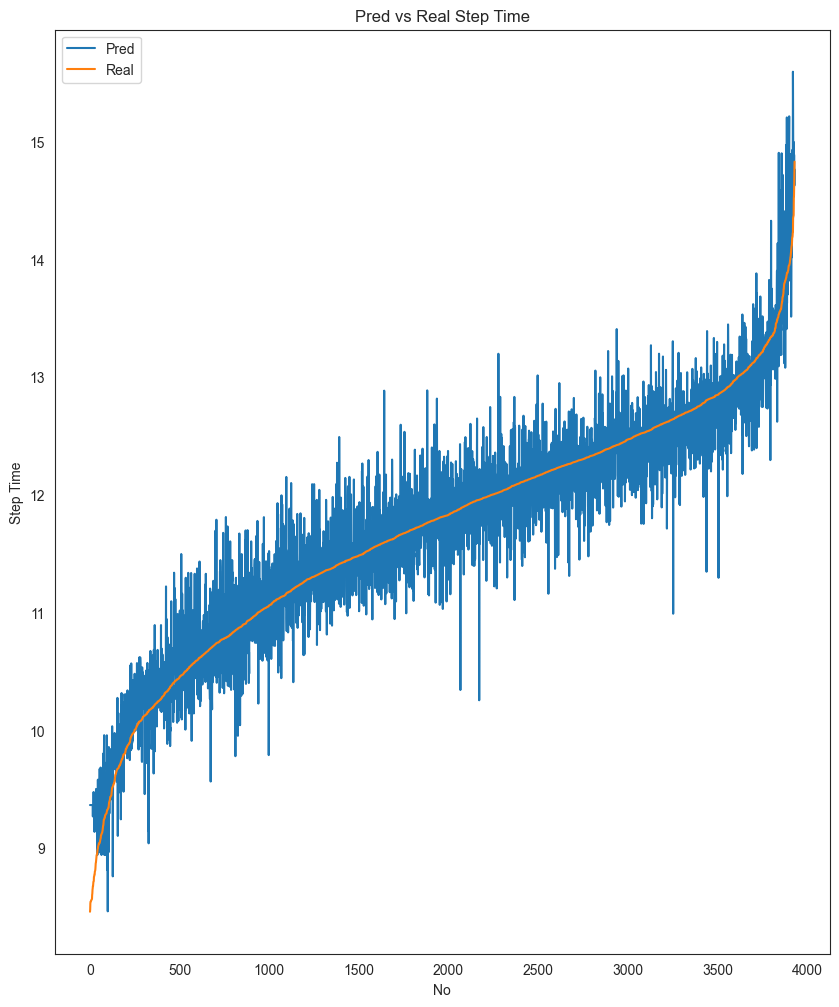

In [40]:
draw_pred_lines(list(y_data_pred), y_data["steps_time"].to_list())

# kernel='sigmoid'

In [41]:
svr_regressor = SVR(kernel="sigmoid")
svr_regressor.fit(x_train, y_train)

y_train_pred = svr_regressor.predict(x_train)
y_test_pred = svr_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)


svr_regressor = SVR(kernel="sigmoid")
svr_regressor.fit(x_data, y_data)

y_data_pred = svr_regressor.predict(x_data)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)
print("ALL RMSE:", rmse_all)

D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN Root Mean Squared Error(RMSE): 15.773522523207808
TEST Root Mean Squared Error(RMSE): 13.491825062047925


D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ALL RMSE: 21.551448474595233


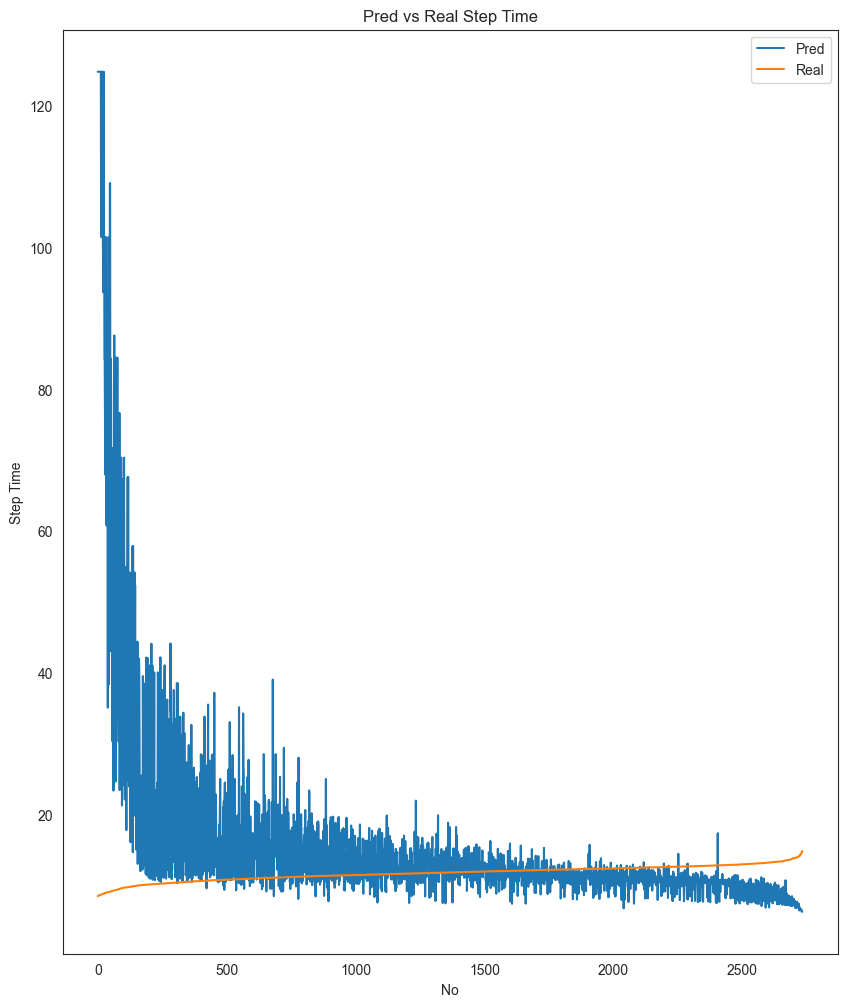

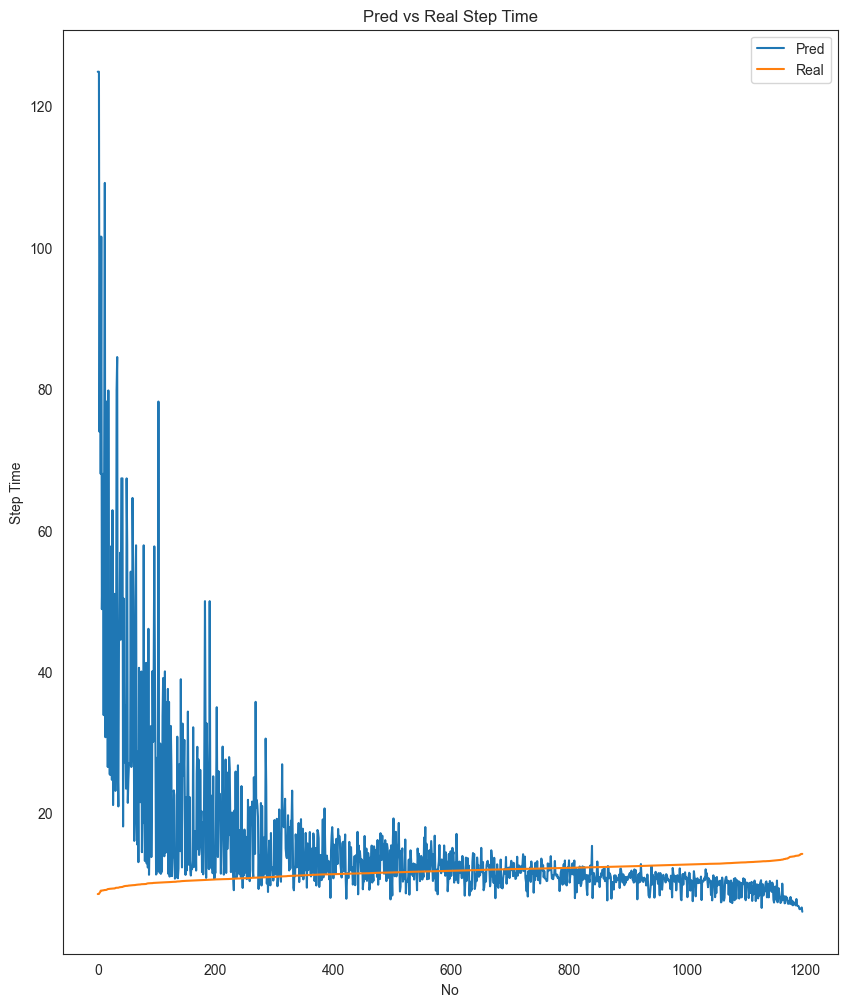

In [42]:
draw_pred_lines(list(y_train_pred), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred), y_test["steps_time"].to_list())

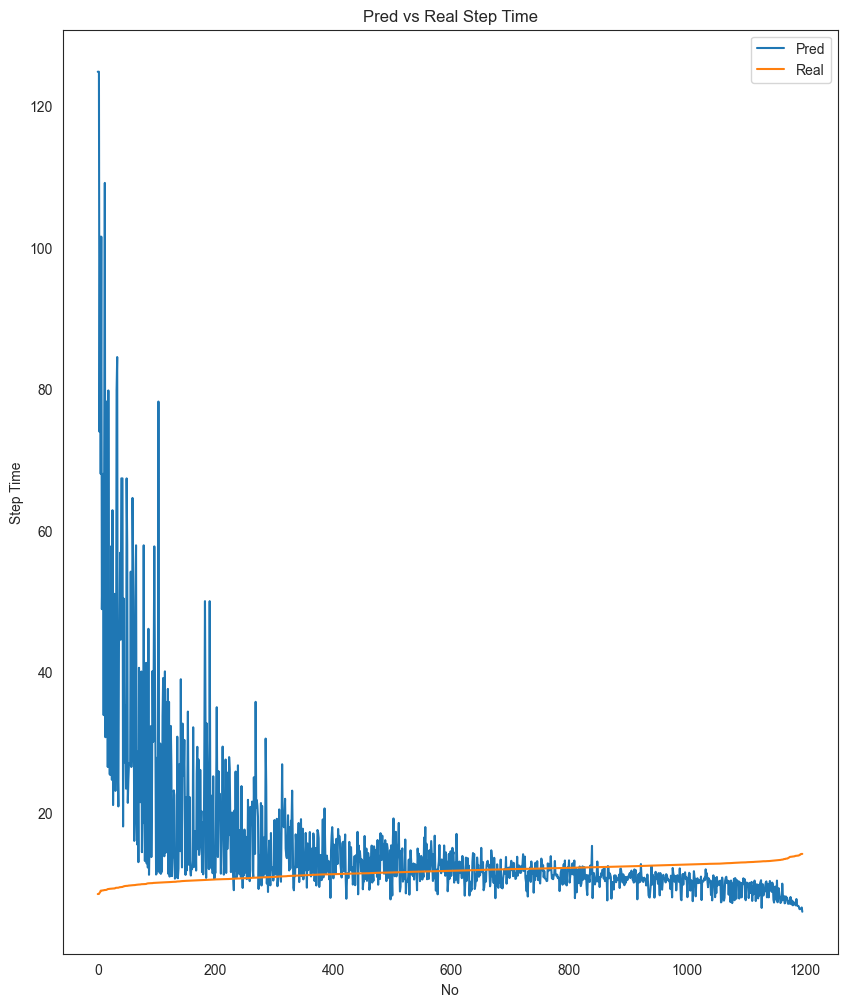

In [43]:
draw_pred_lines(list(y_test_pred), y_test["steps_time"].to_list())

# 5. K-Nearest Neighbors Regression

In [44]:
neighbors = 3

knn_regressor = KNeighborsRegressor(n_neighbors=neighbors)
knn_regressor.fit(x_train, y_train)

y_train_pred = knn_regressor.predict(x_train)
y_test_pred = knn_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)


knn_regressor = KNeighborsRegressor(n_neighbors=neighbors)
knn_regressor.fit(x_data, y_data)

y_data_pred = knn_regressor.predict(x_data)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)
print("ALL RMSE:", rmse_all)

TRAIN Root Mean Squared Error(RMSE): 0.21054423812307207
TEST Root Mean Squared Error(RMSE): 0.3217380847302908
ALL RMSE: 0.21217301173664954


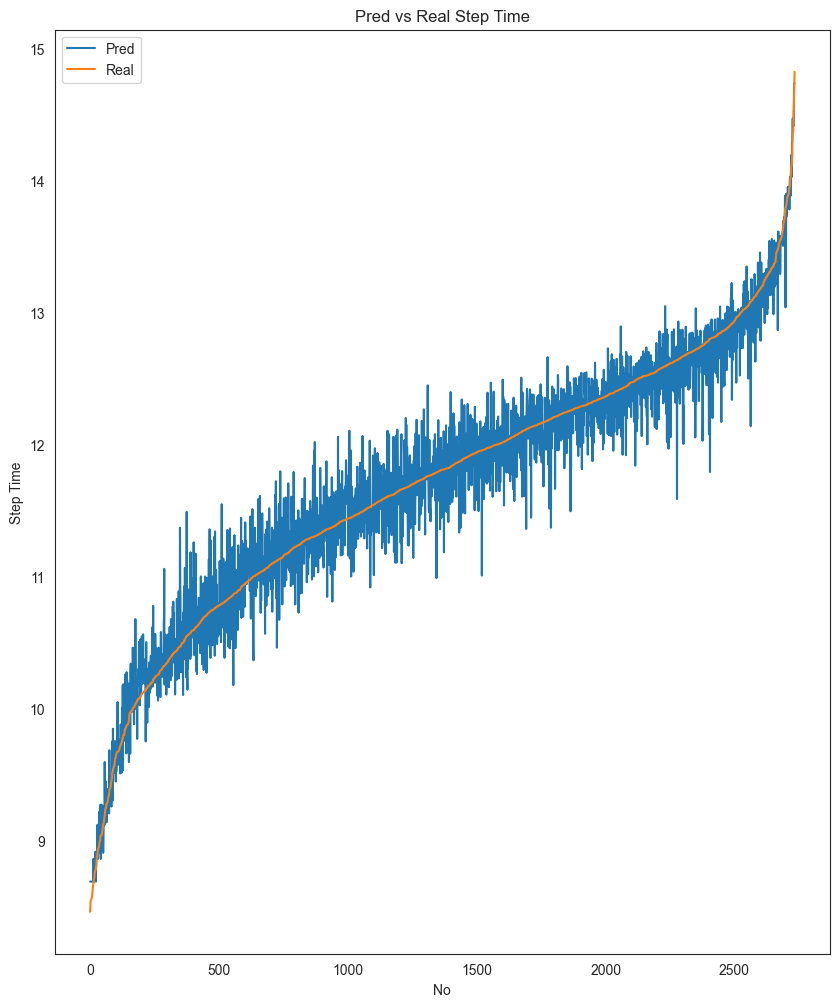

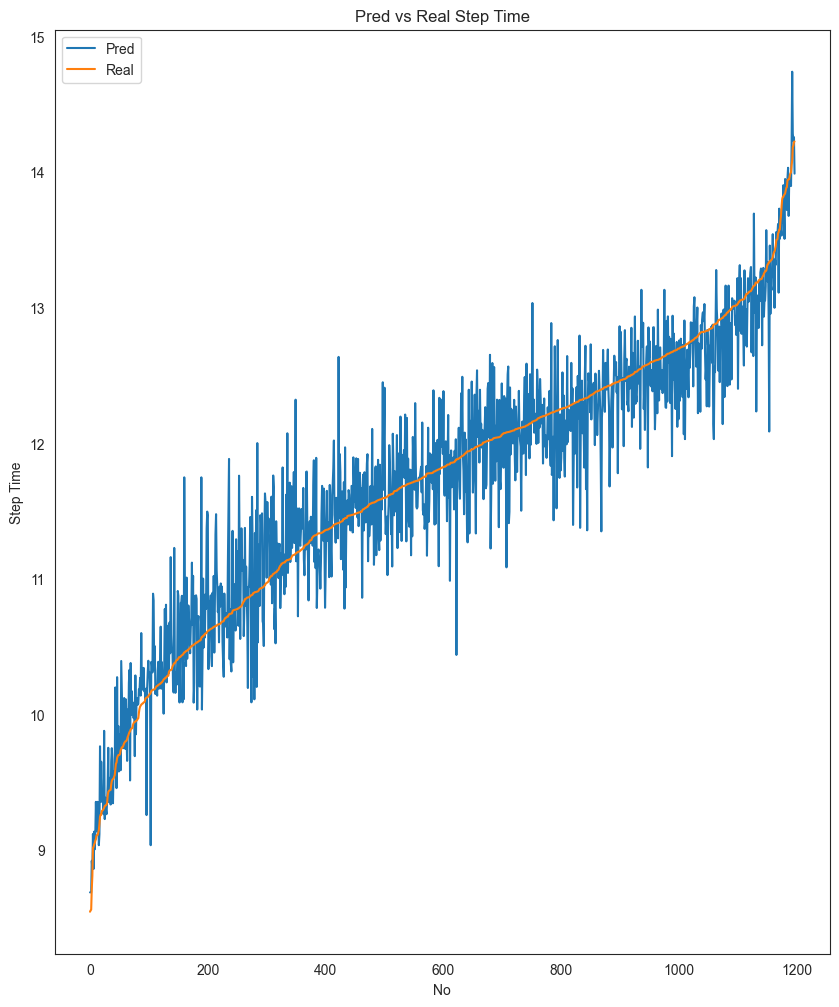

In [45]:
draw_pred_lines(list(y_train_pred), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred), y_test["steps_time"].to_list())

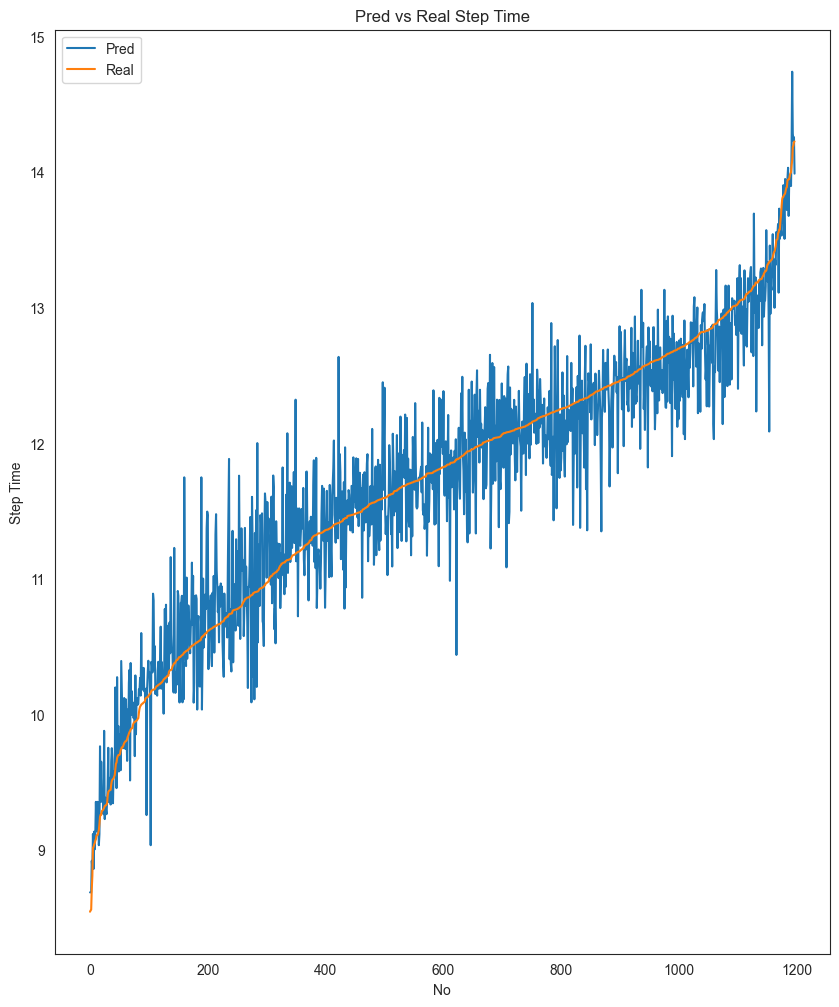

In [46]:
draw_pred_lines(list(y_test_pred), y_test["steps_time"].to_list())

In [47]:
neighbors = 6

knn_regressor = KNeighborsRegressor(n_neighbors=neighbors)
knn_regressor.fit(x_train, y_train)

y_train_pred = knn_regressor.predict(x_train)
y_test_pred = knn_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)


knn_regressor = KNeighborsRegressor(n_neighbors=neighbors)
knn_regressor.fit(x_data, y_data)

y_data_pred = knn_regressor.predict(x_data)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)
print("ALL RMSE:", rmse_all)

TRAIN Root Mean Squared Error(RMSE): 0.2407651984559552
TEST Root Mean Squared Error(RMSE): 0.3053339387570884
ALL RMSE: 0.24298332584072244


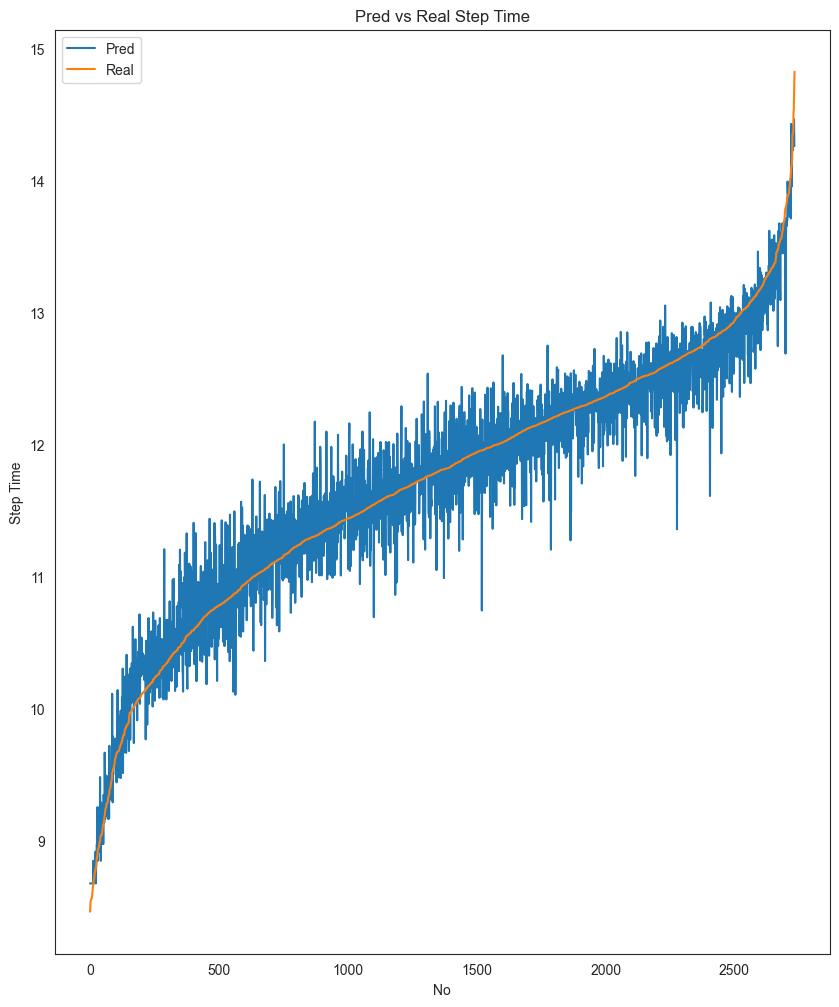

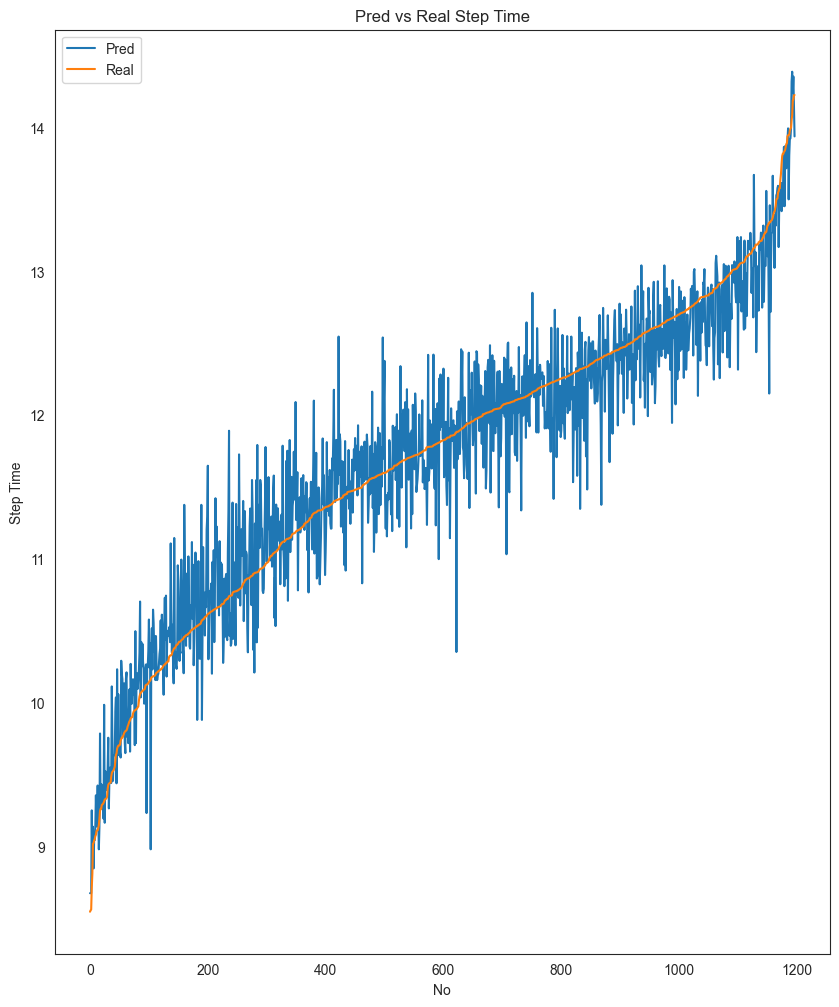

In [48]:
draw_pred_lines(list(y_train_pred), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred), y_test["steps_time"].to_list())

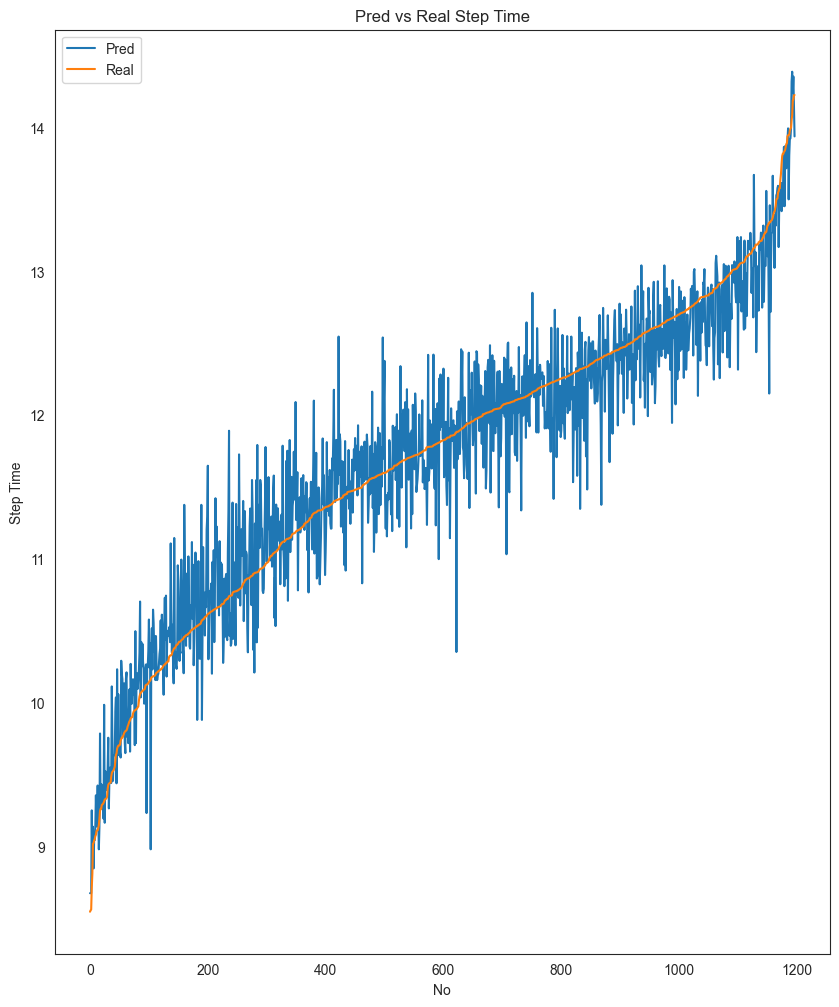

In [49]:
draw_pred_lines(list(y_test_pred), y_test["steps_time"].to_list())

In [50]:
neighbors = 10

knn_regressor = KNeighborsRegressor(n_neighbors=neighbors)
knn_regressor.fit(x_train, y_train)

y_train_pred = knn_regressor.predict(x_train)
y_test_pred = knn_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)


knn_regressor = KNeighborsRegressor(n_neighbors=neighbors)
knn_regressor.fit(x_data, y_data)

y_data_pred = knn_regressor.predict(x_data)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)
print("ALL RMSE:", rmse_all)

TRAIN Root Mean Squared Error(RMSE): 0.25744436145190897
TEST Root Mean Squared Error(RMSE): 0.30202008426653076
ALL RMSE: 0.2596625481572741


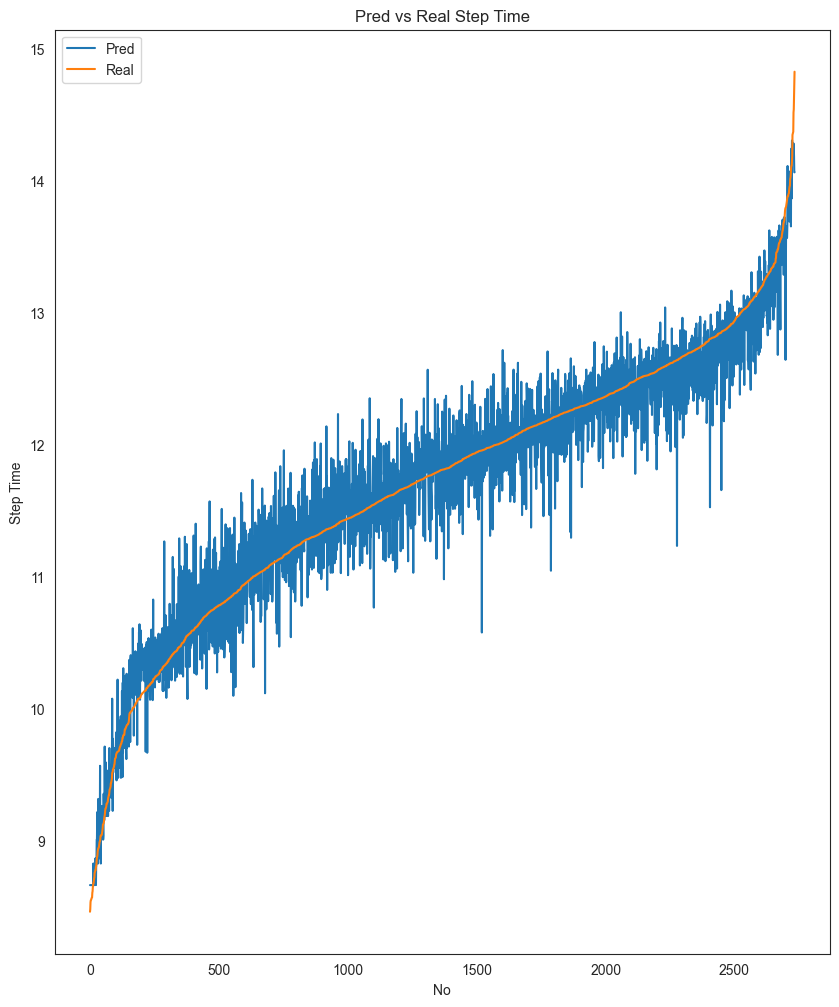

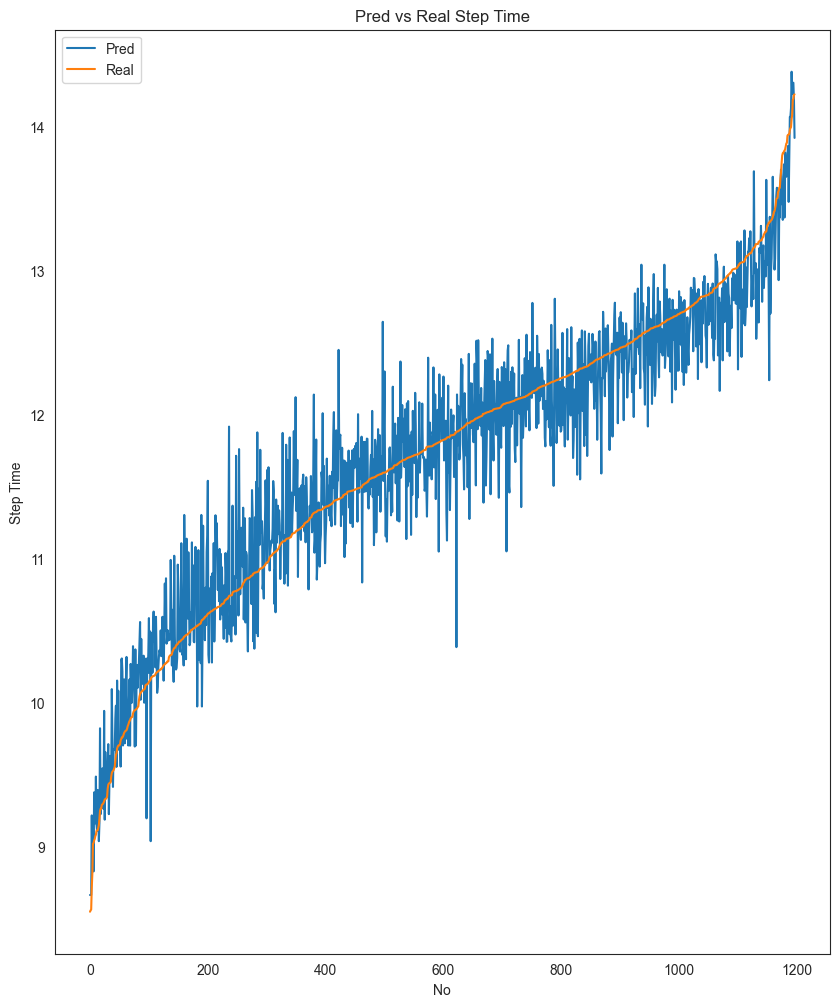

In [51]:
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

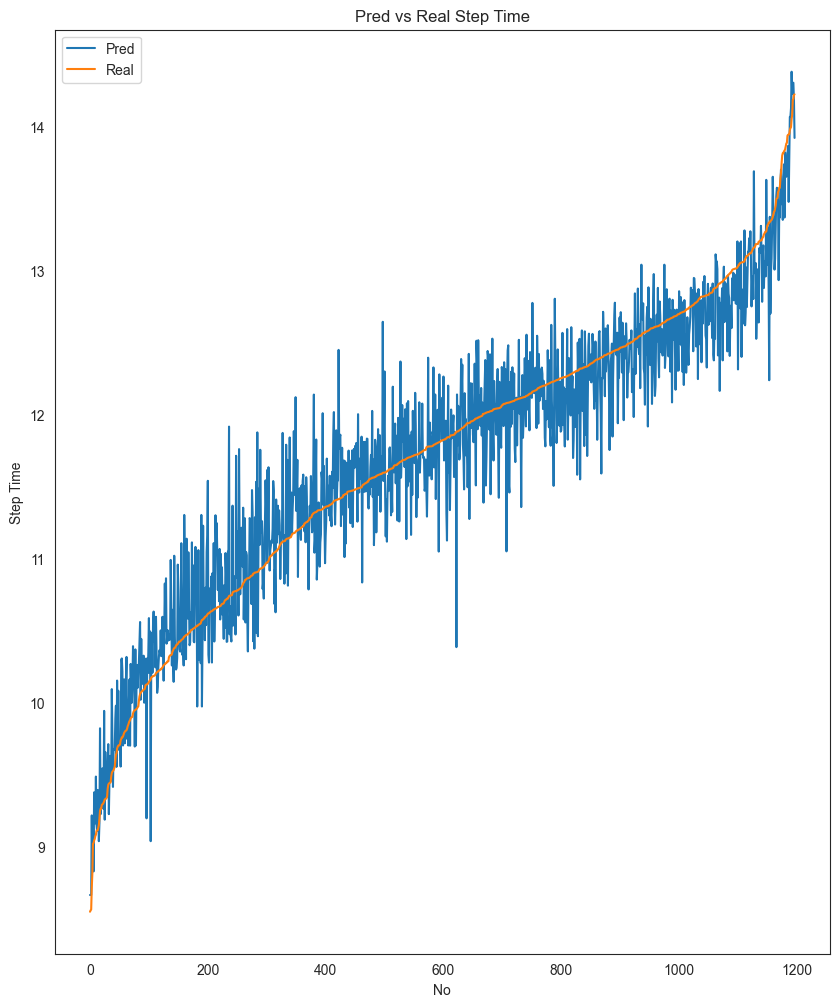

In [52]:
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

In [53]:
neighbors = 20

knn_regressor = KNeighborsRegressor(n_neighbors=neighbors)
knn_regressor.fit(x_train, y_train)

y_train_pred = knn_regressor.predict(x_train)
y_test_pred = knn_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)


knn_regressor = KNeighborsRegressor(n_neighbors=neighbors)
knn_regressor.fit(x_data, y_data)

y_data_pred = knn_regressor.predict(x_data)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)
print("ALL RMSE:", rmse_all)

TRAIN Root Mean Squared Error(RMSE): 0.275342199182871
TEST Root Mean Squared Error(RMSE): 0.30615849733236083
ALL RMSE: 0.2728992909591506


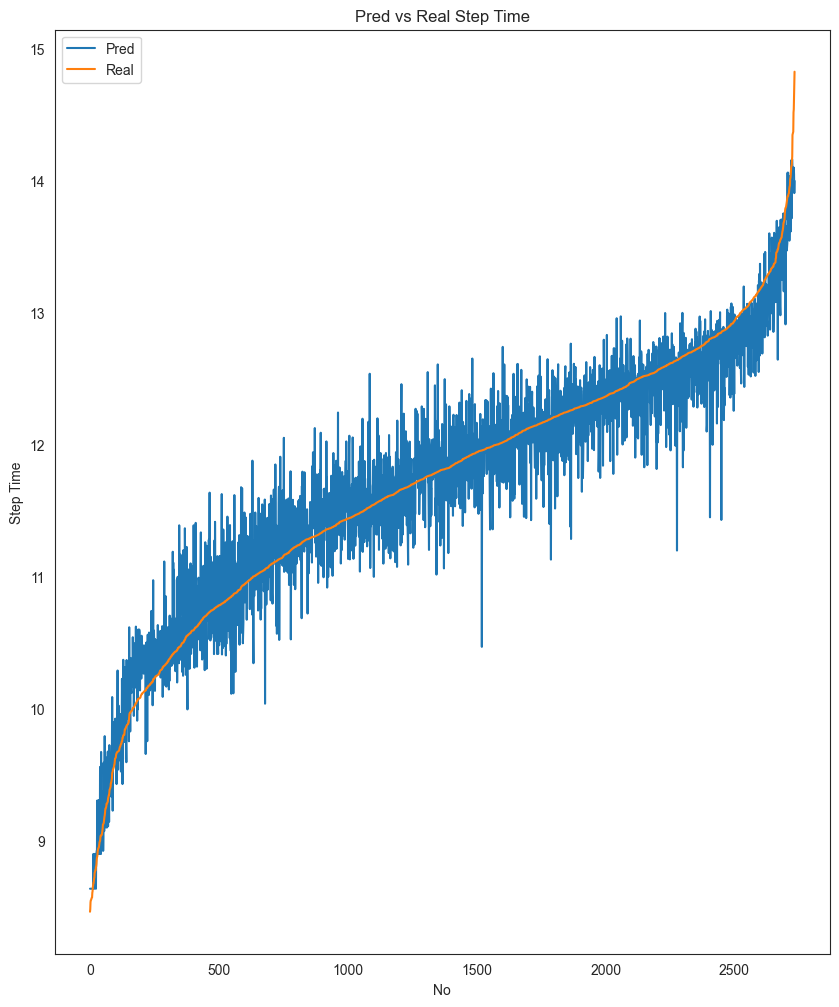

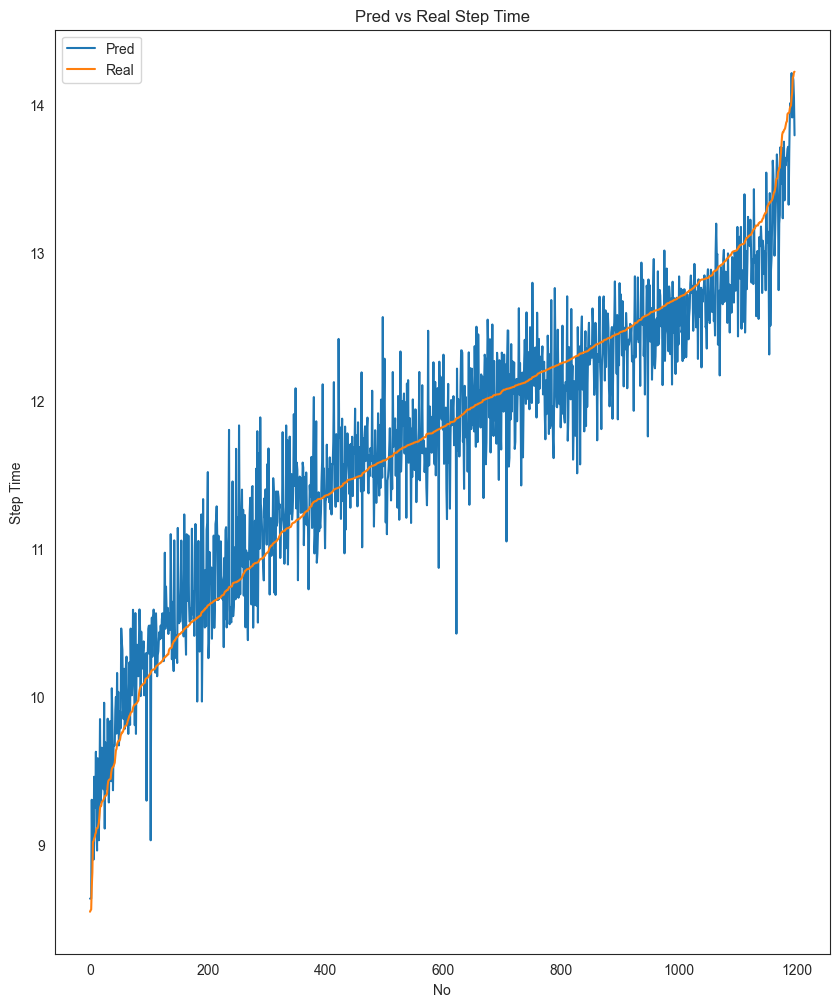

In [54]:
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

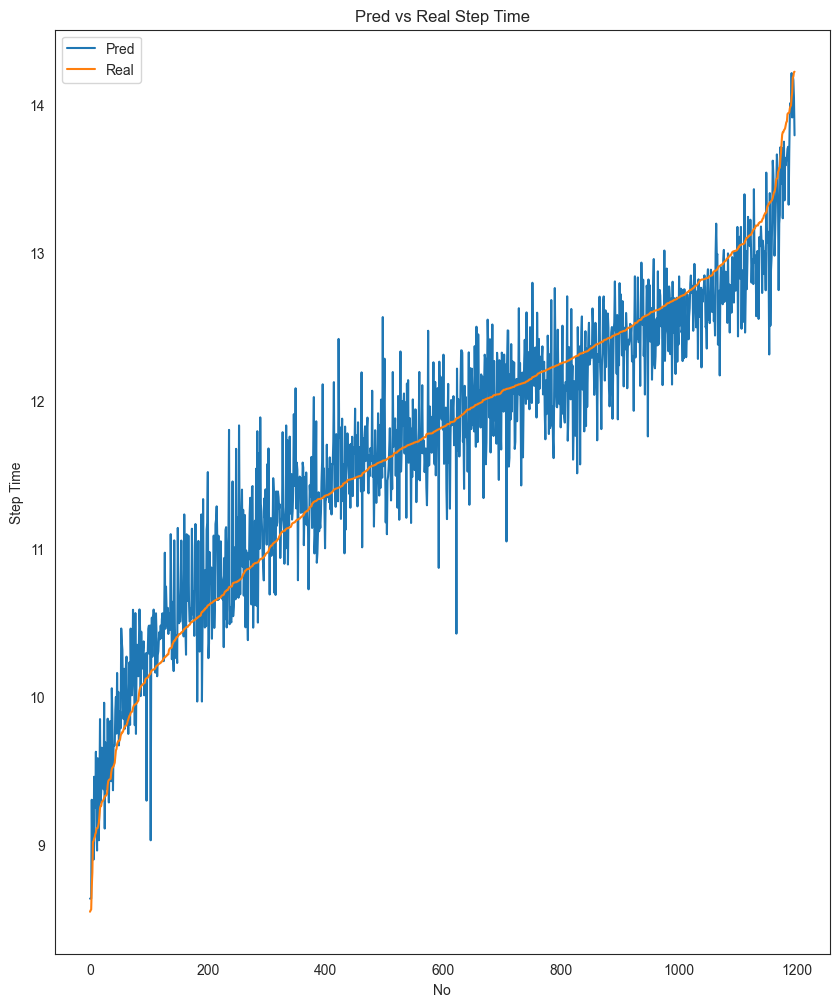

In [55]:
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

# 6. ANN Regression

In [56]:
rcParams["figure.figsize"] = 7, 5

In [57]:
model = Sequential()
model.add(Dense(units=10, activation='relu', input_dim=5))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='rmsprop')

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=300)

Epoch 1/100
10/10 [==============================] - 1s 19ms/step - loss: 149.4504 - val_loss: 138.8073
Epoch 2/100
10/10 [==============================] - 0s 4ms/step - loss: 133.9064 - val_loss: 126.6087
Epoch 3/100
10/10 [==============================] - 0s 4ms/step - loss: 122.5015 - val_loss: 115.9554
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 112.2823 - val_loss: 106.1233
Epoch 5/100
10/10 [==============================] - 0s 4ms/step - loss: 102.7753 - val_loss: 97.0163
Epoch 6/100
10/10 [==============================] - 0s 4ms/step - loss: 93.9204 - val_loss: 88.3938
Epoch 7/100
10/10 [==============================] - 0s 4ms/step - loss: 85.4748 - val_loss: 79.9346
Epoch 8/100
10/10 [==============================] - 0s 4ms/step - loss: 76.9573 - val_loss: 71.3577
Epoch 9/100
10/10 [==============================] - 0s 4ms/step - loss: 68.4323 - val_loss: 62.9230
Epoch 10/100
10/10 [==============================] - 0s 4ms/step - loss: 60.1869

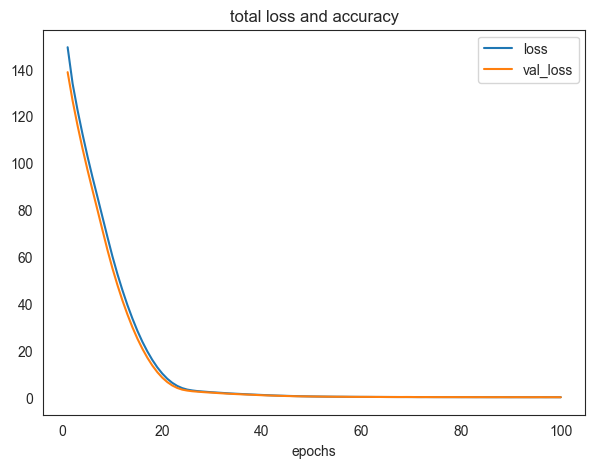

In [58]:
epoch_array = range(1, len(history.history['loss']) + 1)
loss_array = history.history['loss']
val_loss_array = history.history['val_loss']

plt.plot(epoch_array, loss_array, label="loss")
plt.plot(epoch_array, val_loss_array, label="val_loss")
plt.xlabel("epochs")
plt.title("total loss and accuracy")

plt.legend()
plt.show()

In [59]:
y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
y_data_pred = model.predict(x_data)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)
print("ALL RMSE:", rmse_all)

123/123 [==============================] - 0s 717us/step
TRAIN Root Mean Squared Error(RMSE): 0.36792702698010016
TEST Root Mean Squared Error(RMSE): 0.3694919059100386
ALL RMSE: 0.3684042464451566


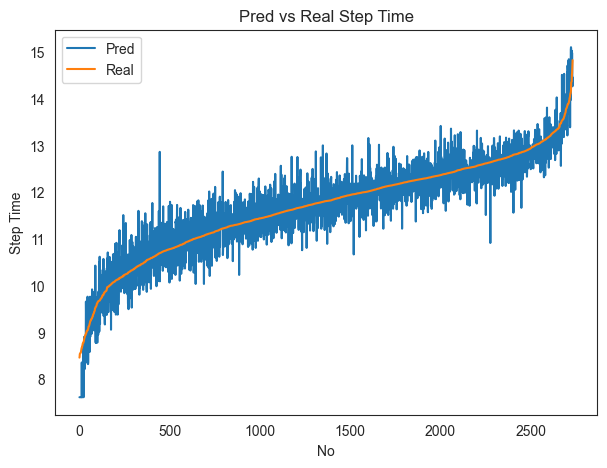

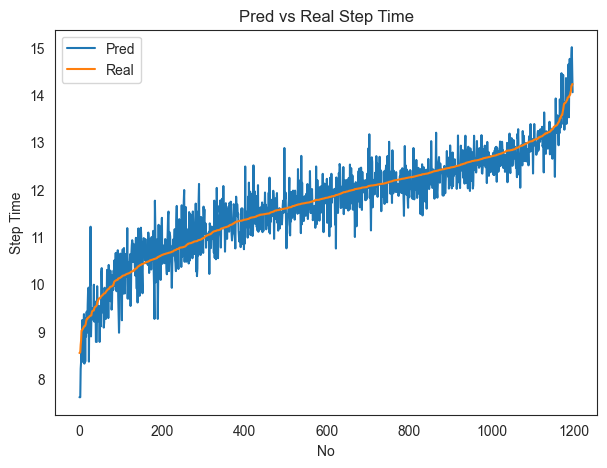

In [60]:
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

In [61]:
model = Sequential()
model.add(Dense(units=10, activation='relu', input_dim=5))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='rmsprop')

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=1)

Epoch 1/5
2734/2734 [==============================] - 4s 1ms/step - loss: 3.5559 - val_loss: 0.4070
Epoch 2/5
2734/2734 [==============================] - 4s 1ms/step - loss: 0.3125 - val_loss: 0.2927
Epoch 3/5
2734/2734 [==============================] - 3s 1ms/step - loss: 0.1954 - val_loss: 0.1584
Epoch 4/5
2734/2734 [==============================] - 3s 1ms/step - loss: 0.1519 - val_loss: 0.1332
Epoch 5/5
2734/2734 [==============================] - 3s 1ms/step - loss: 0.1311 - val_loss: 0.1365


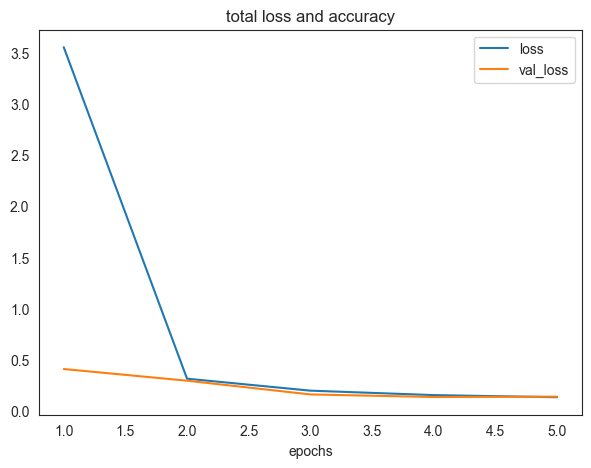

In [62]:
epoch_array = range(1, len(history.history['loss']) + 1)
loss_array = history.history['loss']
val_loss_array = history.history['val_loss']

plt.plot(epoch_array, loss_array, label="loss")
plt.plot(epoch_array, val_loss_array, label='val_loss')
plt.xlabel("epochs")
plt.title("total loss and accuracy")

plt.legend()
plt.show()

123/123 [==============================] - 0s 746us/step
TRAIN Root Mean Squared Error(RMSE): 0.3644468272942315
TEST Root Mean Squared Error(RMSE): 0.3695129439303508
ALL RMSE: 0.3659969020541339


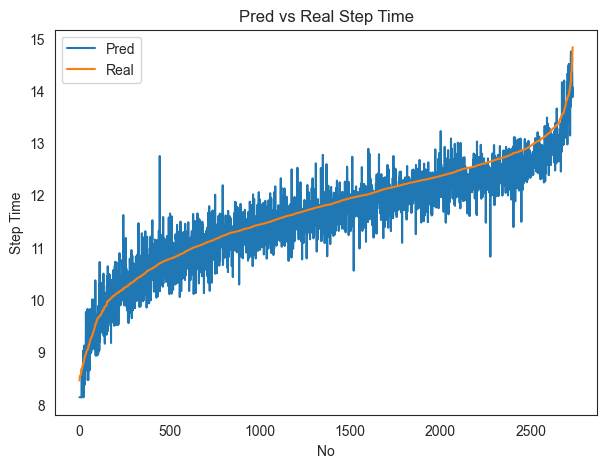

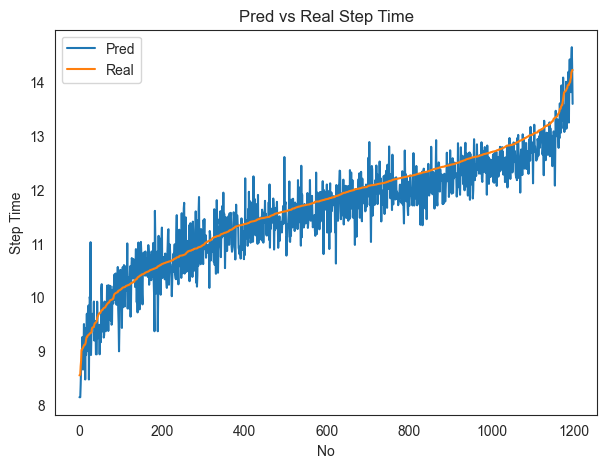

In [63]:
y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
y_data_pred = model.predict(x_data)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)
print("ALL RMSE:", rmse_all)
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

In [64]:
model = Sequential()
model.add(Dense(units=20, activation='relu', input_dim=5))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='rmsprop')

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=1)

Epoch 1/10
2734/2734 [==============================] - 4s 1ms/step - loss: 7.3286 - val_loss: 0.3248
Epoch 2/10
2734/2734 [==============================] - 4s 1ms/step - loss: 0.2740 - val_loss: 0.1955
Epoch 3/10
2734/2734 [==============================] - 3s 1ms/step - loss: 0.1811 - val_loss: 0.1453
Epoch 4/10
2734/2734 [==============================] - 3s 1ms/step - loss: 0.1462 - val_loss: 0.1246
Epoch 5/10
2734/2734 [==============================] - 3s 1ms/step - loss: 0.1313 - val_loss: 0.1366
Epoch 6/10
2734/2734 [==============================] - 3s 1ms/step - loss: 0.1221 - val_loss: 0.1215
Epoch 7/10
2734/2734 [==============================] - 3s 1ms/step - loss: 0.1192 - val_loss: 0.1298
Epoch 8/10
2734/2734 [==============================] - 3s 1ms/step - loss: 0.1124 - val_loss: 0.1218
Epoch 9/10
2734/2734 [==============================] - 3s 1ms/step - loss: 0.1105 - val_loss: 0.1284
Epoch 10/10
2734/2734 [==============================] - 3s 1ms/step - loss: 0.107

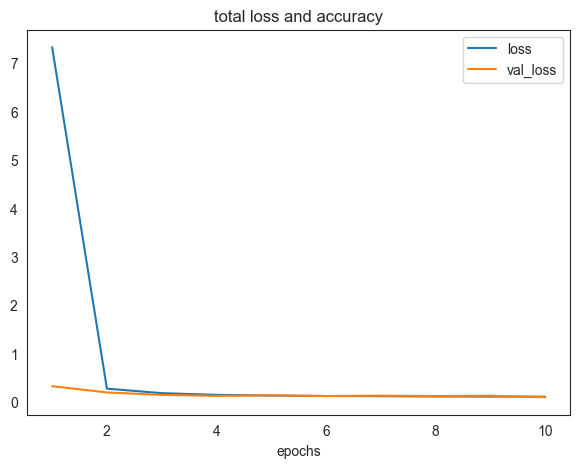

In [65]:
epoch_array = range(1, len(history.history['loss']) + 1)
loss_array = history.history['loss']
val_loss_array = history.history['val_loss']

plt.plot(epoch_array, loss_array, label="loss")
plt.plot(epoch_array, val_loss_array, label='val_loss')
plt.xlabel("epochs")
plt.title("total loss and accuracy")

plt.legend()
plt.show()

123/123 [==============================] - 0s 763us/step
TRAIN Root Mean Squared Error(RMSE): 0.30169687555783914
TEST Root Mean Squared Error(RMSE): 0.31152194847326126
ALL RMSE: 0.30472218899392867


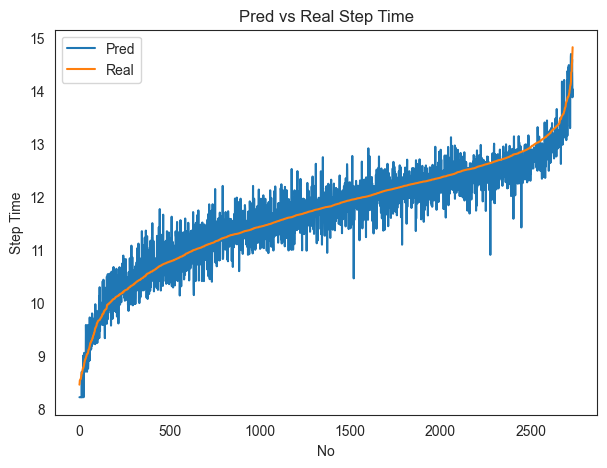

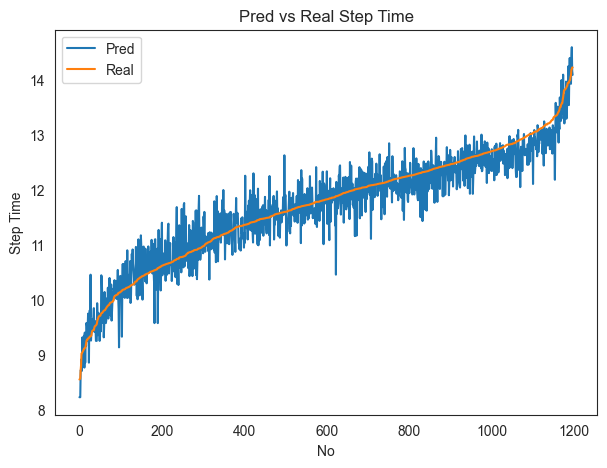

In [66]:
y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
y_data_pred = model.predict(x_data)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)
print("ALL RMSE:", rmse_all)
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

In [67]:
model = Sequential()
model.add(Dense(units=20, activation='relu', input_dim=5))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='rmsprop')

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=1)

Epoch 1/10
2734/2734 [==============================] - 4s 1ms/step - loss: 3.3638 - val_loss: 0.4649
Epoch 2/10
2734/2734 [==============================] - 3s 1ms/step - loss: 0.2920 - val_loss: 0.1689
Epoch 3/10
2734/2734 [==============================] - 4s 1ms/step - loss: 0.1441 - val_loss: 0.1203
Epoch 4/10
2734/2734 [==============================] - 3s 1ms/step - loss: 0.1169 - val_loss: 0.1028
Epoch 5/10
2734/2734 [==============================] - 3s 1ms/step - loss: 0.1099 - val_loss: 0.1099
Epoch 6/10
2734/2734 [==============================] - 3s 1ms/step - loss: 0.1071 - val_loss: 0.1315
Epoch 7/10
2734/2734 [==============================] - 3s 1ms/step - loss: 0.1041 - val_loss: 0.0977
Epoch 8/10
2734/2734 [==============================] - 3s 1ms/step - loss: 0.1021 - val_loss: 0.0934
Epoch 9/10
2734/2734 [==============================] - 3s 1ms/step - loss: 0.1016 - val_loss: 0.1084
Epoch 10/10
2734/2734 [==============================] - 3s 1ms/step - loss: 0.100

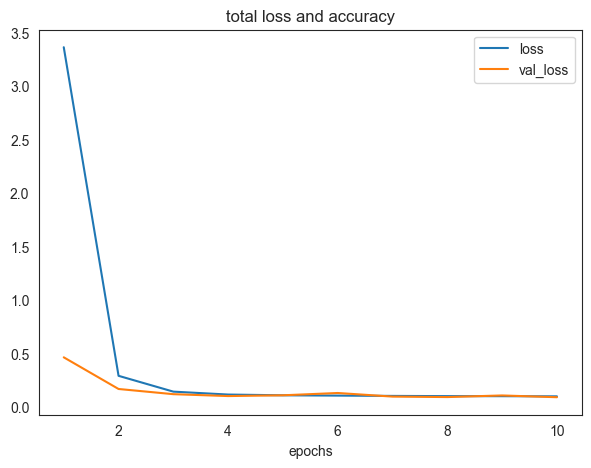

In [68]:
epoch_array = range(1, len(history.history['loss']) + 1)
loss_array = history.history['loss']
val_loss_array = history.history['val_loss']

plt.plot(epoch_array, loss_array, label="loss")
plt.plot(epoch_array, val_loss_array, label='val_loss')
plt.xlabel("epochs")
plt.title("total loss and accuracy")

plt.legend()
plt.show()

123/123 [==============================] - 0s 745us/step
TRAIN Root Mean Squared Error(RMSE): 0.29330282601122215
TEST Root Mean Squared Error(RMSE): 0.30316710543049014
ALL RMSE: 0.29634128979786445


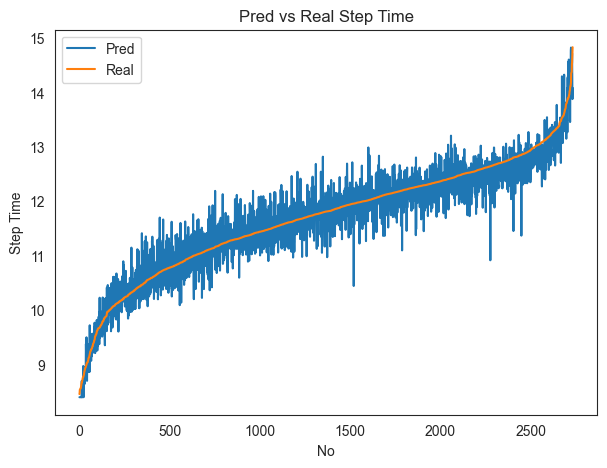

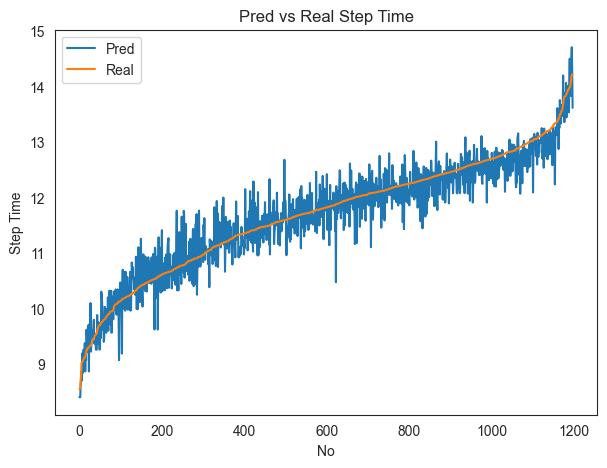

In [69]:
y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
y_data_pred = model.predict(x_data)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)
print("ALL RMSE:", rmse_all)
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

In [70]:
model = Sequential()
model.add(Dense(units=30, activation='relu', input_dim=5))
model.add(Dense(units=20, activation='relu', input_dim=5))
model.add(Dense(units=10, activation='relu', input_dim=5))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='rmsprop')

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=1)

Epoch 1/20
2734/2734 [==============================] - 4s 1ms/step - loss: 5.2969 - val_loss: 0.2014
Epoch 2/20
2734/2734 [==============================] - 4s 1ms/step - loss: 0.1947 - val_loss: 0.1158
Epoch 3/20
2734/2734 [==============================] - 3s 1ms/step - loss: 0.1629 - val_loss: 0.1321
Epoch 4/20
2734/2734 [==============================] - 3s 1ms/step - loss: 0.1476 - val_loss: 0.1128
Epoch 5/20
2734/2734 [==============================] - 3s 1ms/step - loss: 0.1348 - val_loss: 0.3945
Epoch 6/20
2734/2734 [==============================] - 3s 1ms/step - loss: 0.1340 - val_loss: 0.0963
Epoch 7/20
2734/2734 [==============================] - 3s 1ms/step - loss: 0.1274 - val_loss: 0.1048
Epoch 8/20
2734/2734 [==============================] - 3s 1ms/step - loss: 0.1226 - val_loss: 0.1476
Epoch 9/20
2734/2734 [==============================] - 3s 1ms/step - loss: 0.1202 - val_loss: 0.1276
Epoch 10/20
2734/2734 [==============================] - 3s 1ms/step - loss: 0.119

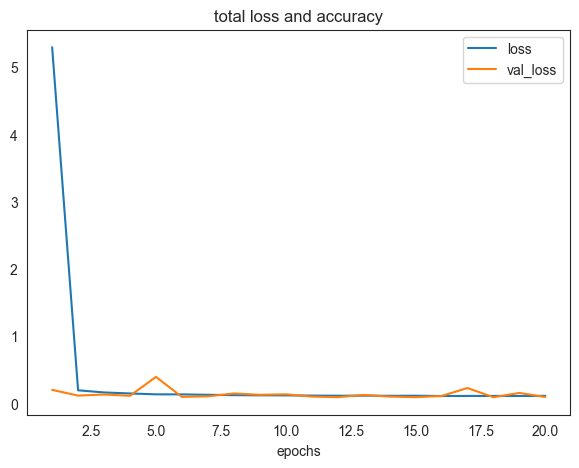

123/123 [==============================] - 0s 780us/step


In [71]:
epoch_array = range(1, len(history.history['loss']) + 1)
loss_array = history.history['loss']
val_loss_array = history.history['val_loss']

plt.plot(epoch_array, loss_array, label="loss")
plt.plot(epoch_array, val_loss_array, label='val_loss')
plt.xlabel("epochs")
plt.title("total loss and accuracy")

plt.legend()
plt.show()
y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
y_data_pred = model.predict(x_data)

123/123 [==============================] - 0s 831us/step
TRAIN Root Mean Squared Error(RMSE): 0.2954042203463818
TEST Root Mean Squared Error(RMSE): 0.30779234083731905
ALL RMSE: 0.29923074550753886


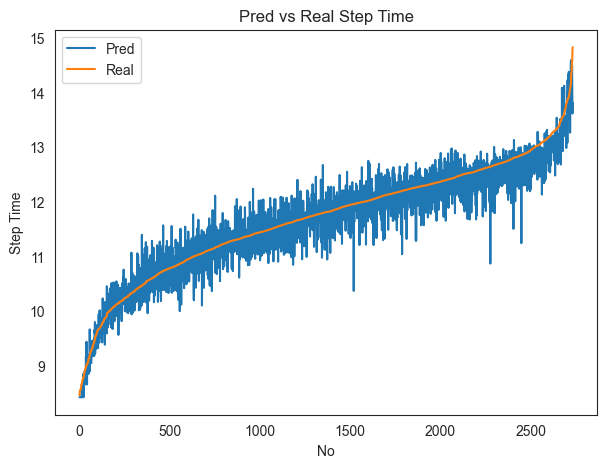

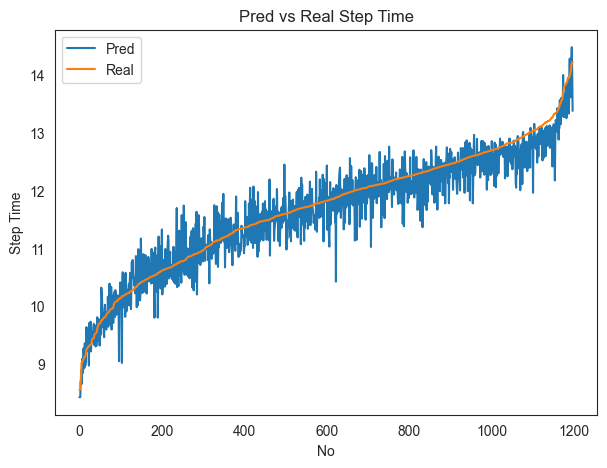

In [72]:
y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
y_data_pred = model.predict(x_data)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)
print("ALL RMSE:", rmse_all)
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())